# **Goal: Recommendation System / Next Best Action**

## **Context**
We have a **random extraction** of a (real world) dataset containing **customers of a large wealth management company**.  

The data is **anonymous, mostly clean, and NOT always normalized/scaled**.  

Our objective is to **estimate investment needs** for these customers using **Data Science techniques**.

### **Why Estimate Investment Needs?**
Identifying customer needs is useful for several reasons, including:

* **Recommender Systems / Next Best Action:**  
  * Needs can serve as **key inputs** for **content-based** or **knowledge-based filtering algorithms**, that allows for personalized services.  
  * This is our **primary focus** in this notebook, i.e., "Know Your Client (KYC)".  

* **Product Targeting & Governance (Regulatory Compliance - MIFID/IDD in EU):**  
  * Regulatory standards require that **customer needs match the investment products offered**. So financial institutions must estimate customer needs.
  * This is essentially an **"institutional view"** of a recommendation system...

<br>

---

## **Dataset Overview**
The dataset, named **"Needs"**, is stored in an **Excel file called Dataset2_Needs.xls**.  
It contains several **potentially relevant features** along with two **target variables**, i.e:

* **AccumulationInvestment**  
  * Indicates a customer preference for **accumulation investing**, typically through **dollar-cost averaging** (i.e., investing small amounts at regular intervals over time, say on a monthly basis).  
  * **Binary (Boolean) response:**  
    * `1 = High propensity`.  
    * `0 = Low propensity`.

- **IncomeInvestment**  
  - Indicates a customer preference for **income investing**, typically through **lump-sum investing** (i.e., one-shot investments).  This is because anyone who aspires to obtain income from coupons and dividends must necessarily already have accumulated capital - a typical need of people who are older than their previous need.
  - **Binary (Boolean) response:**  
    - `1 = High propensity`.  
    - `0 = Low propensity`.  

    **Where do these two response variables come from?** From a **revealed preference scheme**: if the client has an advisor who is considered professionally reliable (this eliminates the possibility of conflict of interest) and has purchased a product that satisfies that need, and the client has also purchased it, we can say with good probability that the advisor has identified the need correctly and the client has that need. In other respects, the machine learning model we are building is a clone of the financial advisor.

<br>

Additionally, we have a **second dataset**, **"Products"**, containing investment products (funds, segregated accounts, unit-linked policies), along with:

* **Product Type:**  
  * `1 = Accumulation` (that is, a product that is good for those who have a high need for accumulation investments)
  * `0 = Income`  (that is, a product that is good for those who have a high need for income investments)

* **Risk Level:**  
  * A **normalized risk score** in the range **$[0,1]$**.  
  * This usually represents the normalized value in $[0, 1]$ of the **[Synthetic Risk and Reward Indicator (SRRI)](https://www.esma.europa.eu/sites/default/files/library/2015/11/10_673.pdf)** of the product, an ordinal variable defined in the range ${1, 7}$ starting from continuous data.

<br>

---

## **Recommendation System Approach**
The recommendation system consists of **two key steps**:

1. **Identifying customers with high investment propensity:**  
   - Using **machine learning models**, we aim to classify customers based on **AccumulationInvestment** (`1 = High propensity`) and/or **IncomeInvestment** (`1 = High propensity`).  

2. **Recommending the most suitable product for each customer:**  
   - For each customer, we match the **most appropriate product** based on:  
     - **Investment need** (Accumulation or Income).  
     - **Risk compatibility** (matching product risk level with the customer profile).  
   - This **personalized recommendation** represents the **Next Best Action** for each client.

<br>


<br>

Let's start with data ingestion.

<br>

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load each sheet into separate DataFrames
# Define the file path
file_path = 'Dataset2_Needs_fixed.xlsx'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# **Data Exploration**

As for the last business case: I keep it minimalist, for the benefit of brevity, to be able to get to the heart of the problem. But you could/can spend tons of time here in order to **understand the problem and the dataset**.

Let's display our variables to better understand the data structure and characteristics of the dataset.

<br>

In [4]:
# Let's see the actual variables names in metadata_df
print("Metadata DataFrame columns:")
print(metadata_df.columns.tolist())

# Let's peek at the first few rows
print("\nFirst few rows of metadata:")
print(metadata_df.head())


Metadata DataFrame columns:
['Metadata', 'Unnamed: 1']

First few rows of metadata:
        Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components


<br>

We drop ID column as it's not needed for analysis.

<br>

In [5]:
# Drop ID column and create comprehensive summary
needs_df_no_id = needs_df.drop('ID', axis=1)

# Create enhanced summary statistics
def get_statistics(series):
    stats = {
        'Count': len(series),
        'Unique Values': series.nunique(),
        'Missing Values': series.isnull().sum(),
        'Mean': series.mean(),
        'Median': series.median(),
        'Mode': series.mode().iloc[0] if not series.mode().empty else None,
        'Std Dev': series.std(),
        'Variance': series.var(),
        'Min': series.min(),
        '25th Percentile': series.quantile(0.25),
        '75th Percentile': series.quantile(0.75),
        'Max': series.max(),
        'Range': series.max() - series.min(),
        'IQR': series.quantile(0.75) - series.quantile(0.25),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Outliers (IQR)': len(series[((series < (series.quantile(0.25) - 1.5 * (series.quantile(0.75) - series.quantile(0.25)))) | 
                                    (series > (series.quantile(0.75) + 1.5 * (series.quantile(0.75) - series.quantile(0.25)))))]),
        'CV': (series.std() / series.mean()) * 100 if series.mean() != 0 else None
    }
    return stats

# Calculate statistics for each column
summary_data = []
for column in needs_df_no_id.columns:
    stats = get_statistics(needs_df_no_id[column])
    stats['Column'] = column
    summary_data.append(stats)

# Create DataFrame with statistics
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.set_index('Column')

# Round numeric columns to 2 decimal places
numeric_columns = summary_df.select_dtypes(include=[np.number]).columns
summary_df[numeric_columns] = summary_df[numeric_columns].round(2)

# Display the summary table with styling
styled_summary = summary_df.style\
    .format(precision=2)\
    .background_gradient(cmap='YlOrRd', subset=['Missing Values'])\
    .background_gradient(cmap='YlOrRd', subset=['Skewness'])\
    .background_gradient(cmap='YlOrRd', subset=['Kurtosis'])\
    .background_gradient(cmap='YlOrRd', subset=['Outliers (IQR)'])\
    .set_properties(**{'text-align': 'center'})\
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]},
        {'selector': 'caption', 'props': [('caption-side', 'top')]}
    ])\
    .set_caption('Enhanced Dataset Summary Statistics (Excluding ID)')

display(styled_summary)

# Print additional insights with better formatting
print("\nKey Insights:")
print("1. Target Variables Distribution:")
income_dist = needs_df_no_id['IncomeInvestment'].value_counts(normalize=True).round(3) * 100
accum_dist = needs_df_no_id['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100
print(f"   - IncomeInvestment:")
print(f"     * Yes: {income_dist[1]:.1f}%")
print(f"     * No:  {income_dist[0]:.1f}%")
print(f"   - AccumulationInvestment:")
print(f"     * Yes: {accum_dist[1]:.1f}%")
print(f"     * No:  {accum_dist[0]:.1f}%")

print("\n2. Feature Characteristics:")
print(f"   - Age Range: {needs_df_no_id['Age'].min()} to {needs_df_no_id['Age'].max()} years")
print(f"   - Wealth Range: {needs_df_no_id['Wealth'].min():.2f} to {needs_df_no_id['Wealth'].max():.2f}")
print(f"   - Family Size: {needs_df_no_id['FamilyMembers'].min()} to {needs_df_no_id['FamilyMembers'].max()} members")

print("\n3. Data Quality:")
print(f"   - Missing Values: {needs_df_no_id.isnull().sum().sum()}")
print(f"   - Duplicate Rows: {needs_df_no_id.duplicated().sum()}")

print("\n4. Distribution Insights:")
for col in needs_df_no_id.select_dtypes(include=[np.number]).columns:
    skew = needs_df_no_id[col].skew()
    kurt = needs_df_no_id[col].kurtosis()
    outliers = summary_df.loc[col, 'Outliers (IQR)']
    print(f"   - {col}:")
    print(f"     * Skewness: {skew:.2f} ({'Right-skewed' if skew > 0 else 'Left-skewed' if skew < 0 else 'Symmetric'})")
    print(f"     * Kurtosis: {kurt:.2f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed' if kurt < 0 else 'Normal-like'})")
    print(f"     * Outliers: {outliers} ({outliers/len(needs_df_no_id)*100:.1f}% of data)")

,Count,Unique Values,Missing Values,Mean,Median,Mode,Std Dev,Variance,Min,25th Percentile,75th Percentile,Max,Range,IQR,Skewness,Kurtosis,Outliers (IQR),CV
Column,,,,,,,,,,,,,,,,,,
Age,5000,77,0,55.25,55.00,59.00,11.97,143.32,18.00,47.00,63.00,97.00,79.00,16.00,0.06,-0.03,29,21.67
Gender,5000,2,0,0.49,0.00,0.00,0.50,0.25,0.00,0.00,1.00,1.00,1.00,1.00,0.03,-2.00,0,101.62
FamilyMembers,5000,5,0,2.51,3.00,2.00,0.76,0.58,1.00,2.00,3.00,5.00,4.00,1.00,0.06,-0.21,11,30.35
FinancialEducation,5000,5000,0,0.42,0.42,0.04,0.15,0.02,0.04,0.31,0.52,0.90,0.87,0.22,0.15,-0.42,8,36.12
RiskPropensity,5000,5000,0,0.36,0.35,0.02,0.15,0.02,0.02,0.25,0.47,0.88,0.86,0.22,0.33,-0.35,10,41.67
Income,5000,5000,0,62.99,53.40,1.54,44.36,1967.79,1.54,30.60,84.12,365.32,363.79,53.53,1.38,2.86,166,70.42
Wealth,5000,5000,0,93.81,66.07,1.06,105.47,11124.13,1.06,38.31,114.82,2233.23,2232.17,76.51,5.83,67.13,317,112.43
IncomeInvestment,5000,2,0,0.38,0.00,0.00,0.49,0.24,0.00,0.00,1.00,1.00,1.00,1.00,0.48,-1.77,0,126.78
AccumulationInvestment,5000,2,0,0.51,1.00,1.00,0.50,0.25,0.00,0.00,1.00,1.00,1.00,1.00,-0.05,-2.00,0,97.40



Key Insights:
1. Target Variables Distribution:
   - IncomeInvestment:
     * Yes: 38.4%
     * No:  61.6%
   - AccumulationInvestment:
     * Yes: 51.3%
     * No:  48.7%

2. Feature Characteristics:
   - Age Range: 18 to 97 years
   - Wealth Range: 1.06 to 2233.23
   - Family Size: 1 to 5 members

3. Data Quality:
   - Missing Values: 0
   - Duplicate Rows: 0

4. Distribution Insights:
   - Age:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.03 (Light-tailed)
     * Outliers: 29 (0.6% of data)
   - Gender:
     * Skewness: 0.03 (Right-skewed)
     * Kurtosis: -2.00 (Light-tailed)
     * Outliers: 0 (0.0% of data)
   - FamilyMembers:
     * Skewness: 0.06 (Right-skewed)
     * Kurtosis: -0.21 (Light-tailed)
     * Outliers: 11 (0.2% of data)
   - FinancialEducation:
     * Skewness: 0.15 (Right-skewed)
     * Kurtosis: -0.42 (Light-tailed)
     * Outliers: 8 (0.2% of data)
   - RiskPropensity:
     * Skewness: 0.33 (Right-skewed)
     * Kurtosis: -0.35 (Light-tailed)
     *

In [6]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
ID,Numerical ID,2500.50,1443.52,0,1.00,5000.00
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


<br>

## Data Transformation and Exploratory Analysis

### 1. Initial setup
* Import required libraries (seaborn, matplotlib, etc).
* Create utility function for histogram plotting.

### 2. Target variables analysis: are they imbalanced?
* Visualize distribution of Income Investment needs.
* Visualize distribution of Accumulation Investment needs.
* Assess class balance for both target variables.

### 3. Wealth variable transformation analysis: is it too fat-tailed?
Display the fat-tailed shape of the Wealth variable, and effect of a couple of reasonable transformations on the Wealth variable. We examine three versions of the Wealth variable:
* Original Wealth distribution.
* Log transformation.
* Power transformation (0.1 power).
* Evaluate which transformation better normalizes the distribution, identifying the most appropriate transformation for leptokurtic, skewed wealth data.

### 4. Some feature engineering and scaling
* Apply log transformation to Wealth and Income.
* Normalize selected variables using MinMaxScaler.
* Create a standardized feature set for modeling.

### 5. Multivariate analysis
* Generate a correlation matrix heatmap for all numeric variables.
* Create pairwise relationships visualization.
* Examine relationships between transformed variables and target variables.

<br>


CREATING BASELINE DATASET
Dataset shape: (5000, 9)
Target distribution - Income Investment: 
0    61.6
1    38.4
Name: IncomeInvestment, dtype: float64%
Target distribution - Accumulation Investment: 
1    51.3
0    48.7
Name: AccumulationInvestment, dtype: float64%

Baseline Dataset Summary:
Number of features: 9
Feature list: ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income ', 'Wealth', 'Wealth_log', 'Income_log']


CREATING FEATURE-ENGINEERED DATASET
Visualizing original data distributions...


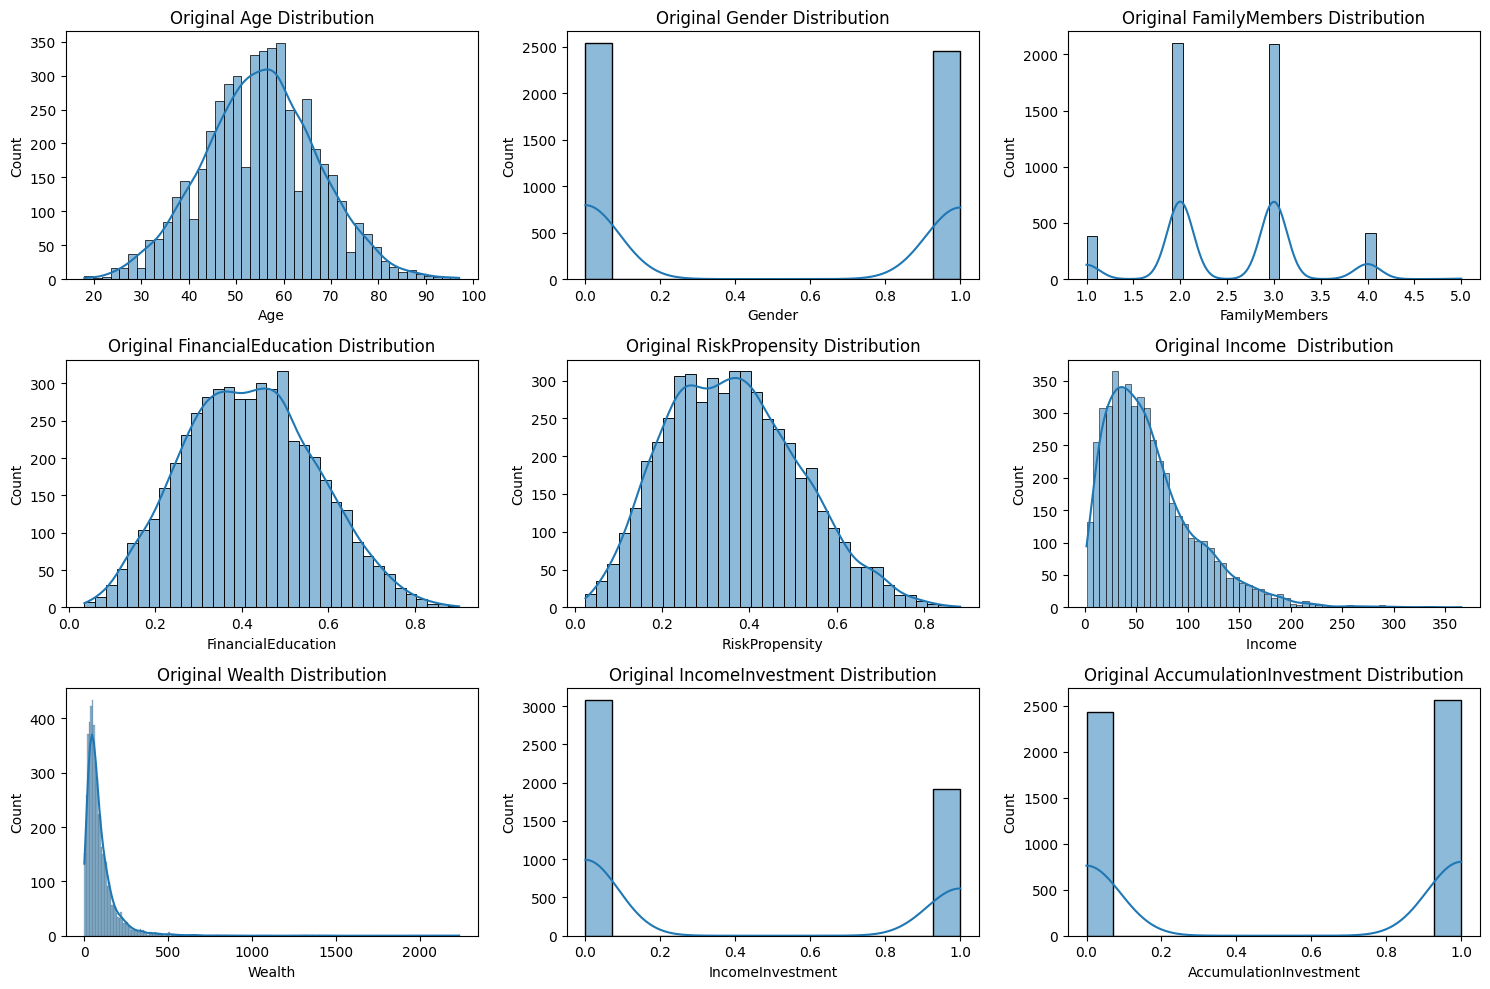


Generating box plots to identify outliers...


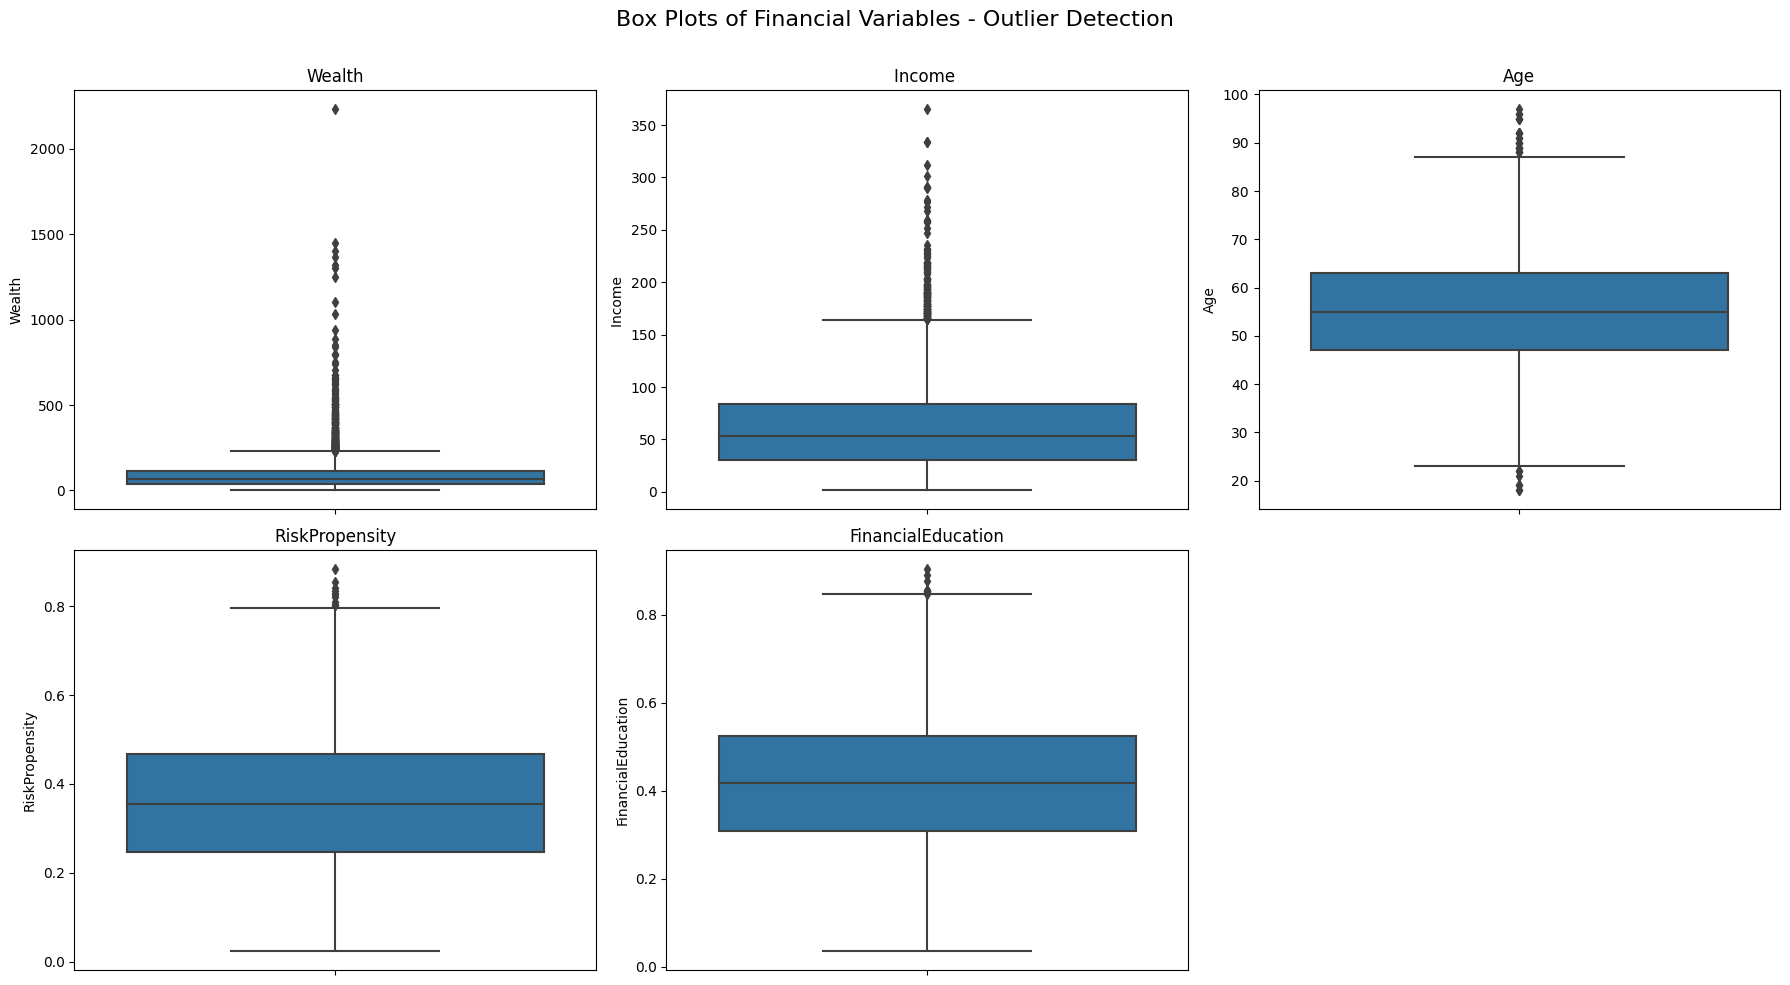

Correlation between Income and Accumulation Investment needs: 0.011


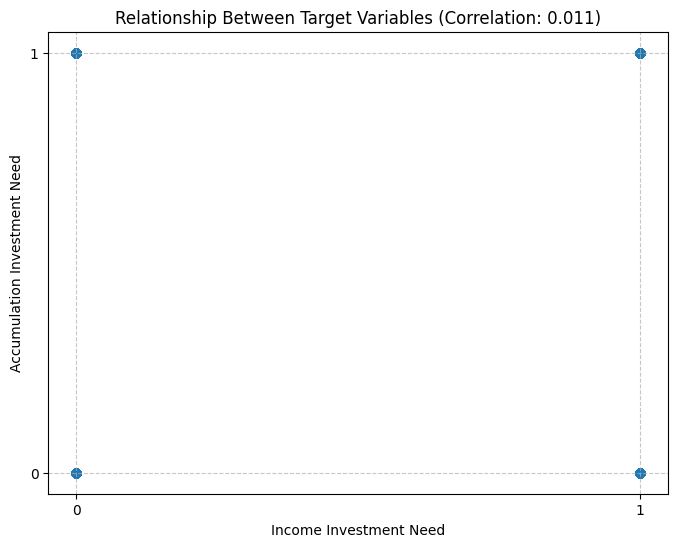


Performing advanced feature engineering...


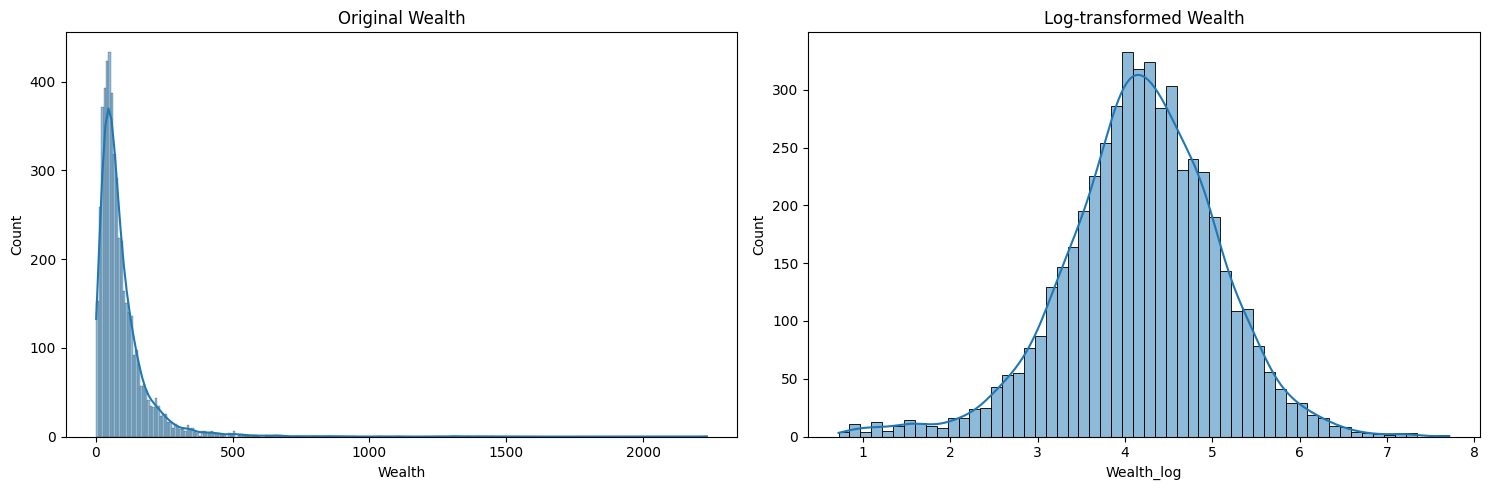

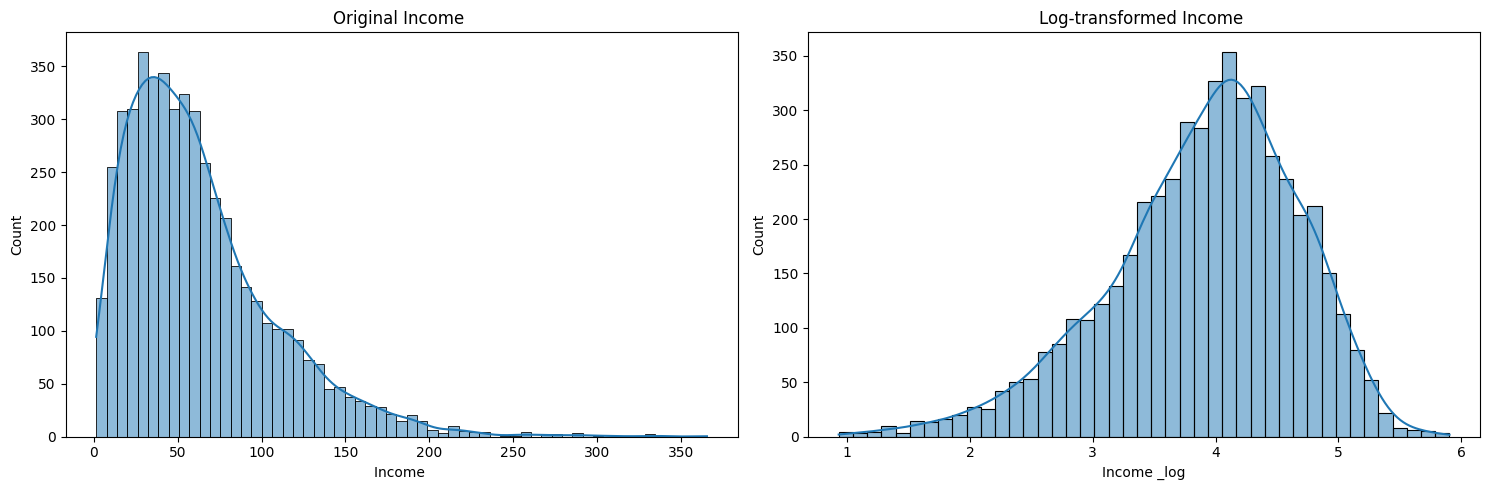

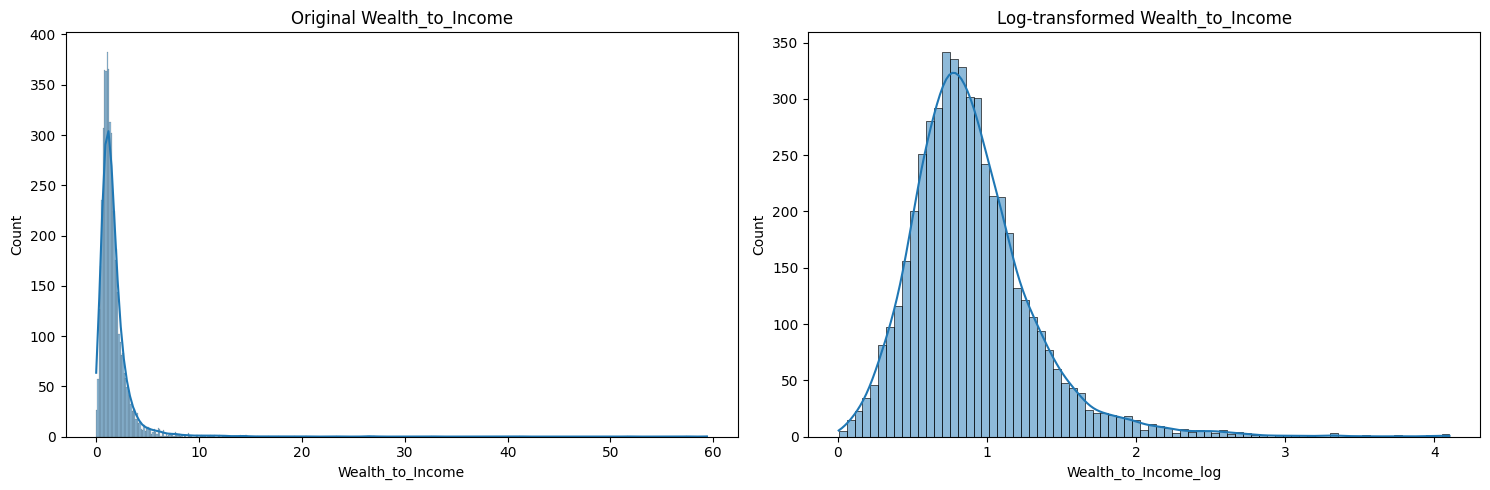

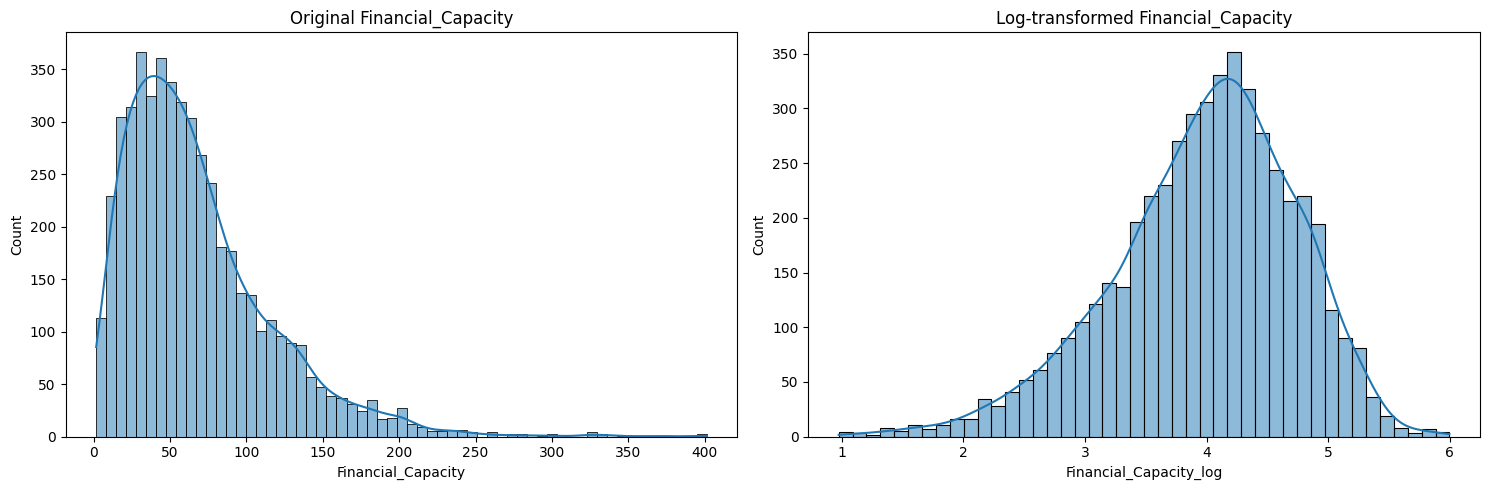

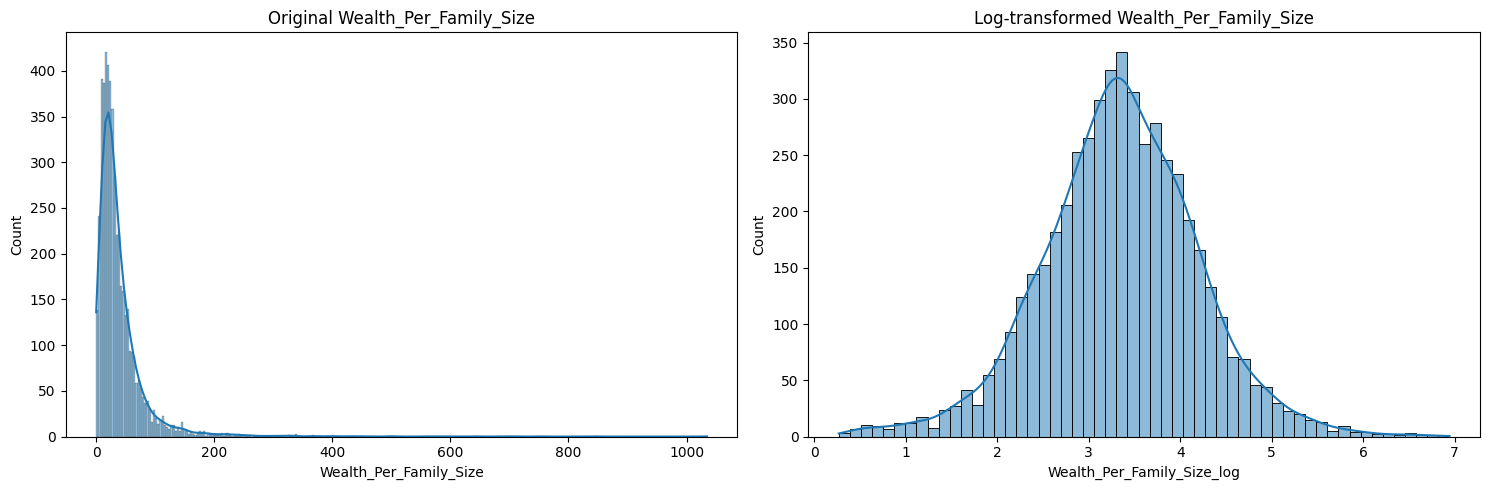

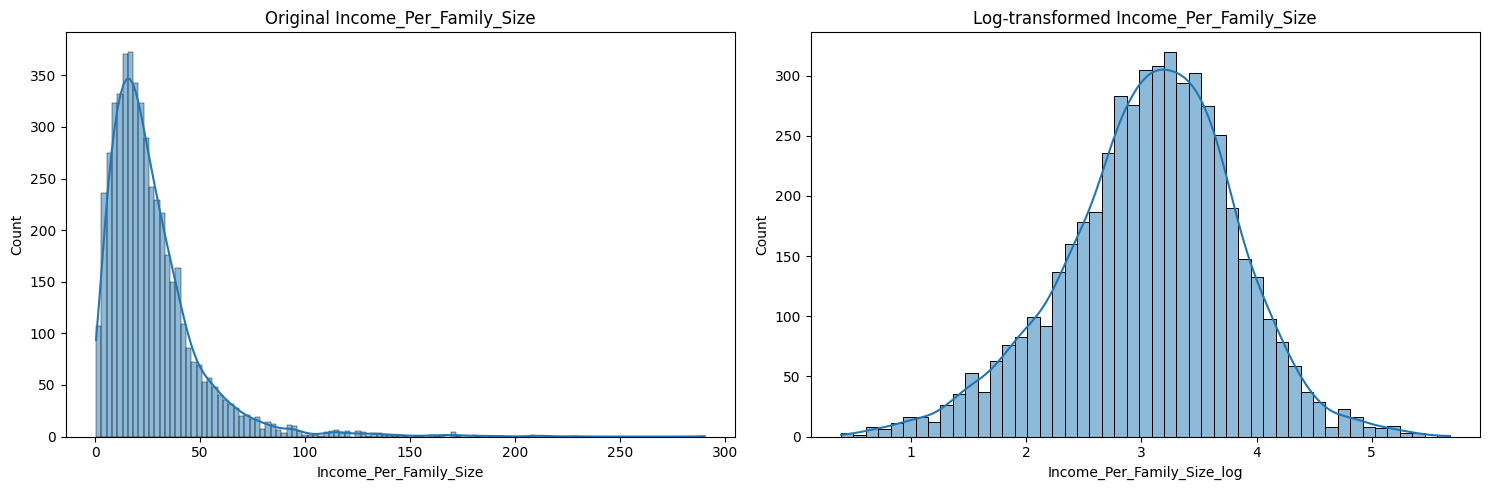

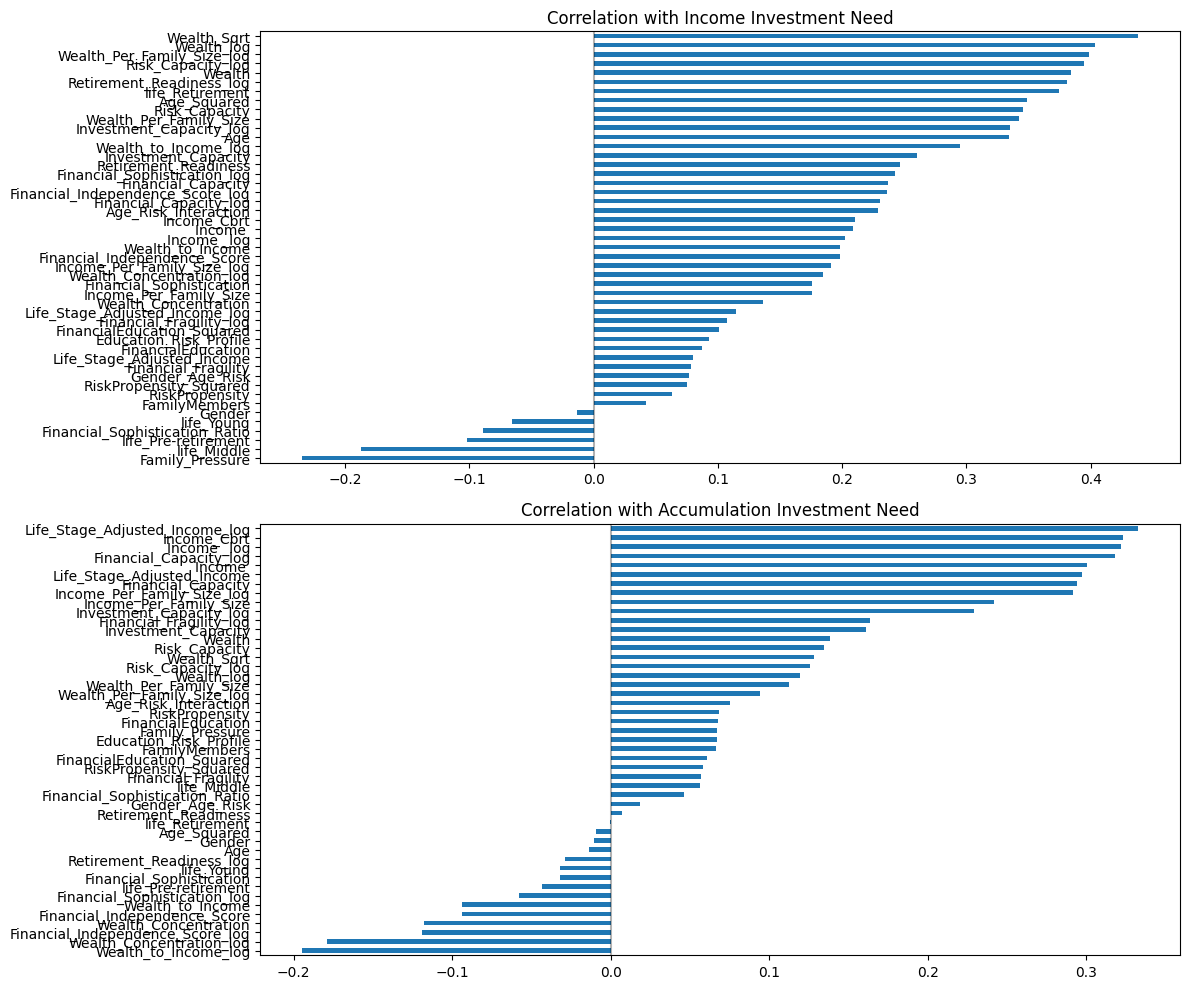

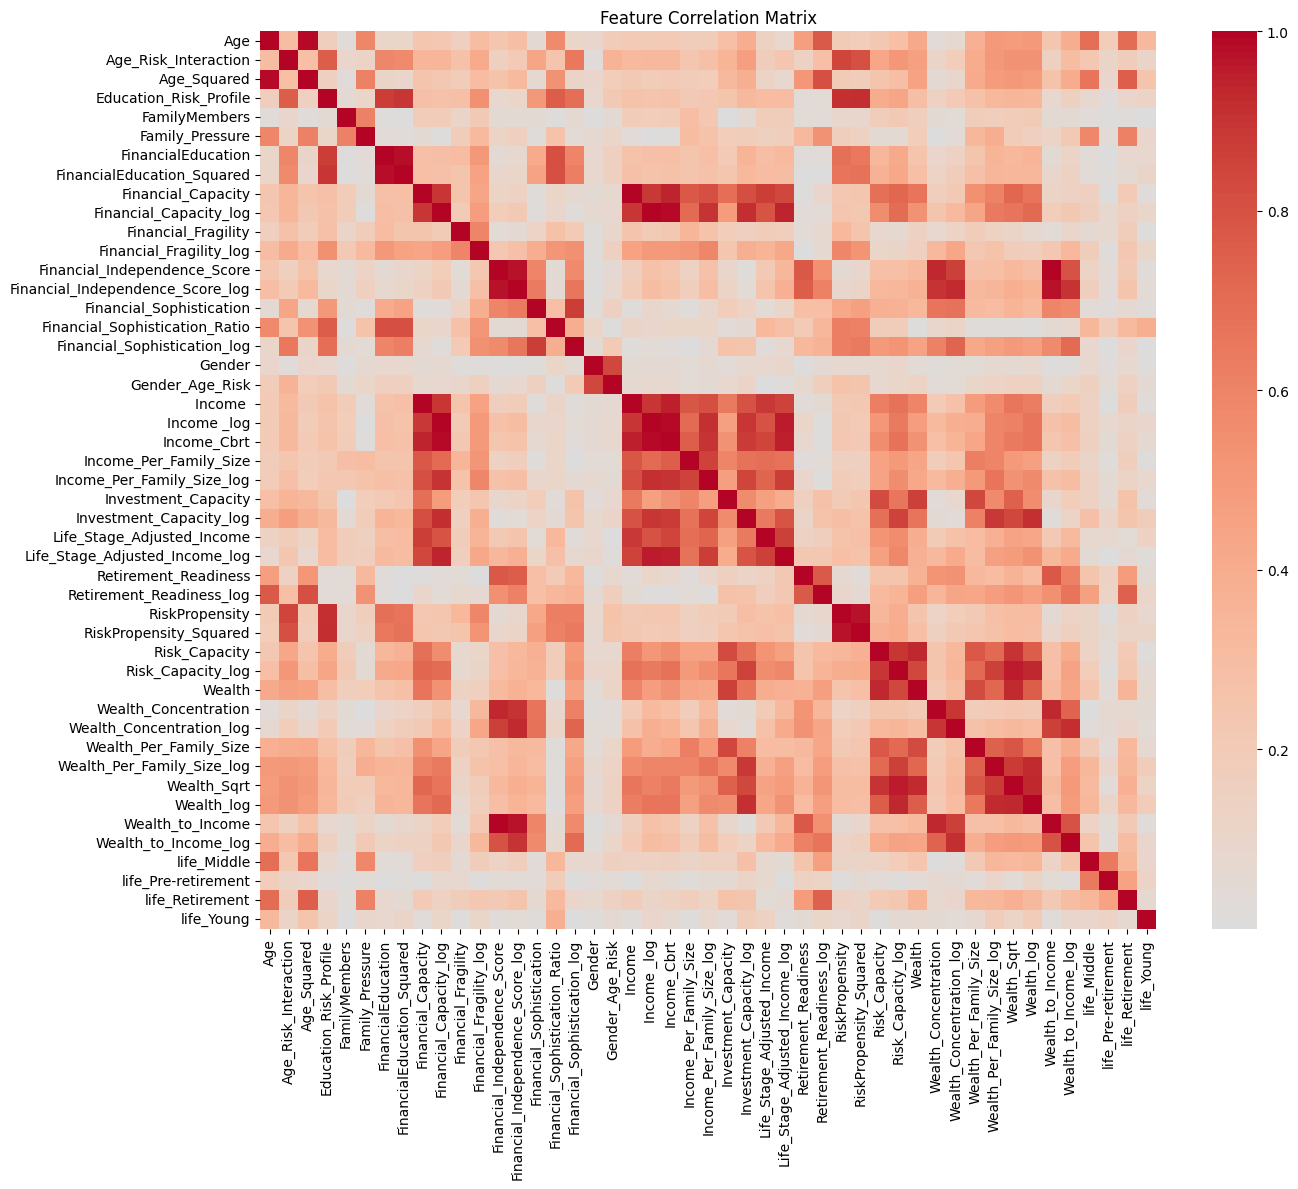


Highly correlated feature pairs (>0.9):
Age - Age_Squared: 0.989
Education_Risk_Profile - RiskPropensity: 0.908
Education_Risk_Profile - RiskPropensity_Squared: 0.921
FinancialEducation - FinancialEducation_Squared: 0.977
Financial_Capacity - Income : 0.996
Financial_Capacity - Income_Cbrt: 0.944
Financial_Capacity_log - Income _log: 0.996
Financial_Capacity_log - Income_Cbrt: 0.985
Financial_Capacity_log - Income_Per_Family_Size_log: 0.902
Financial_Capacity_log - Investment_Capacity_log: 0.917
Financial_Capacity_log - Life_Stage_Adjusted_Income_log: 0.945
Financial_Independence_Score - Financial_Independence_Score_log: 0.974
Financial_Independence_Score - Wealth_Concentration: 0.930
Financial_Independence_Score - Wealth_to_Income: 1.000
Financial_Independence_Score_log - Wealth_Concentration: 0.903
Financial_Independence_Score_log - Wealth_Concentration_log: 0.926
Financial_Independence_Score_log - Wealth_to_Income: 0.974
Financial_Independence_Score_log - Wealth_to_Income_log: 0.90

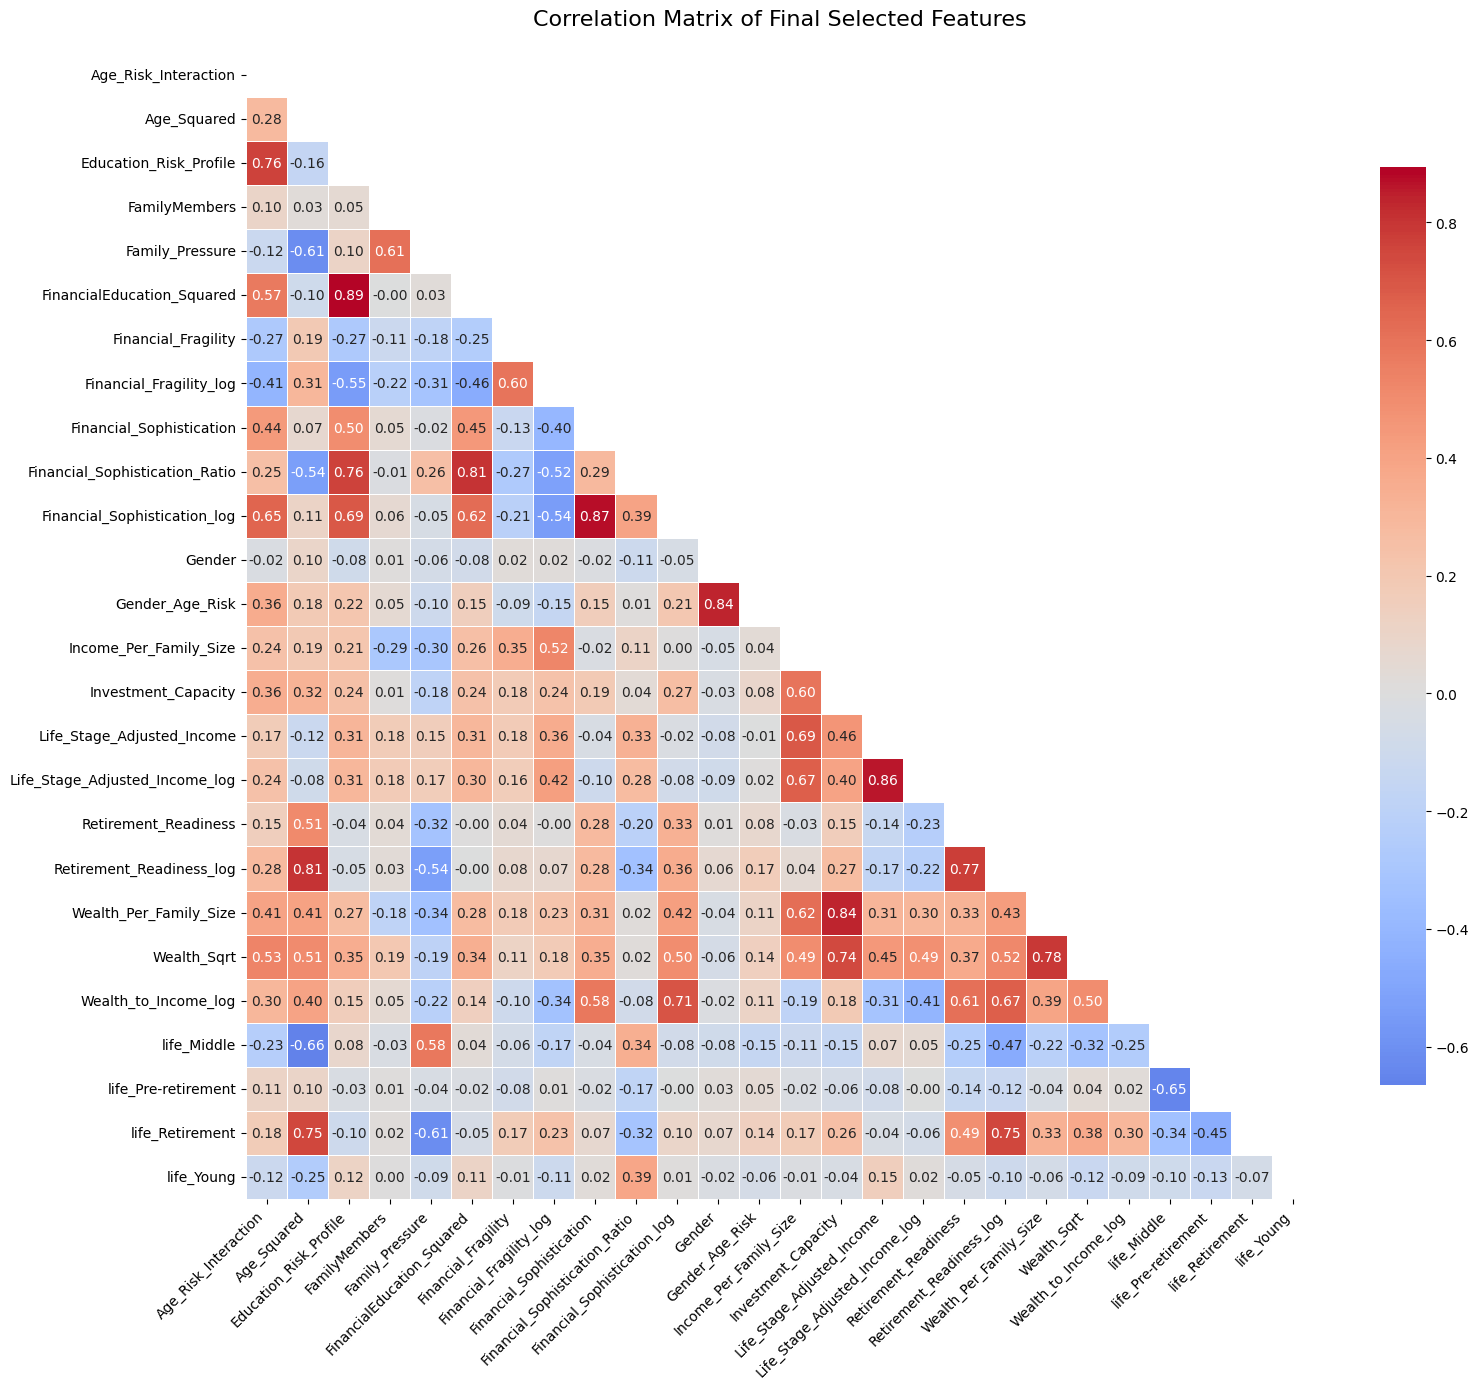


Feature Engineering Summary:
Baseline features: 9
Engineered features (after feature selection): 26

Top 10 features by correlation with targets:
- Wealth_Sqrt: Income=0.438, Accumulation=0.128
- Retirement_Readiness_log: Income=0.381, Accumulation=-0.029
- life_Retirement: Income=0.375, Accumulation=-0.001
- Age_Squared: Income=0.348, Accumulation=-0.009
- Wealth_Per_Family_Size: Income=0.342, Accumulation=0.113
- Life_Stage_Adjusted_Income_log: Income=0.115, Accumulation=0.333
- Life_Stage_Adjusted_Income: Income=0.080, Accumulation=0.297
- Wealth_to_Income_log: Income=0.295, Accumulation=-0.195
- Investment_Capacity: Income=0.260, Accumulation=0.161
- Retirement_Readiness: Income=0.246, Accumulation=0.007

Preprocessing complete. Both baseline and engineered datasets are ready for modeling.
Baseline: X ((5000, 9)), y_income ((5000,)), y_accum ((5000,))
Engineered: X ((5000, 26)), y_income ((5000,)), y_accum ((5000,))


In [7]:
# =====================================================================================
# PART 1: BASELINE DATASET WITH MINIMAL PREPROCESSING
# =====================================================================================

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Load and examine the dataset
print("CREATING BASELINE DATASET")
print("=========================")

# Start with dataset that already has ID removed
baseline_df = needs_df_no_id.copy()

# Print basic information about the dataset
print(f"Dataset shape: {baseline_df.shape}")
print(f"Target distribution - Income Investment: \n{baseline_df['IncomeInvestment'].value_counts(normalize=True).round(3) * 100}%")
print(f"Target distribution - Accumulation Investment: \n{baseline_df['AccumulationInvestment'].value_counts(normalize=True).round(3) * 100}%")

# 2. Basic preprocessing for baseline dataset
# Log transform highly skewed financial variables
baseline_df['Wealth_log'] = np.log1p(baseline_df['Wealth'])
baseline_df['Income_log'] = np.log1p(baseline_df['Income'])

# Scale all numeric features
baseline_scaler = MinMaxScaler()
baseline_numeric = baseline_df.select_dtypes(include=['float64', 'int64']).columns
baseline_df[baseline_numeric] = baseline_scaler.fit_transform(baseline_df[baseline_numeric])

# 3. Split into features and targets
baseline_X = baseline_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
baseline_y_income = baseline_df['IncomeInvestment']
baseline_y_accum = baseline_df['AccumulationInvestment']

# 4. Baseline dataset summary
print("\nBaseline Dataset Summary:")
print(f"Number of features: {baseline_X.shape[1]}")
print(f"Feature list: {baseline_X.columns.tolist()}")

# =====================================================================================
# PART 2: FEATURE-ENGINEERED DATASET WITH ADVANCED PREPROCESSING
# =====================================================================================

print("\n\nCREATING FEATURE-ENGINEERED DATASET")
print("===================================")

# 1. Start fresh with original data
engineered_df = needs_df_no_id.copy()

# 2. Visualize original distributions
print("Visualizing original data distributions...")
plt.figure(figsize=(15, 10))
for i, column in enumerate(engineered_df.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(engineered_df[column], kde=True)
    plt.title(f'Original {column} Distribution')
plt.tight_layout()
plt.show()

# Add boxplots for outlier detection
print("\nGenerating box plots to identify outliers...")
plt.figure(figsize=(18, 10))
plt.suptitle('Box Plots of Financial Variables - Outlier Detection', fontsize=16)
for i, col in enumerate(['Wealth', 'Income', 'Age', 'RiskPropensity', 'FinancialEducation']):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=engineered_df[col])
    plt.title(f'{col}')
    plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# 3. Analyze relationship between target variables
y_income = engineered_df['IncomeInvestment']
y_accum = engineered_df['AccumulationInvestment']
target_correlation = np.corrcoef(y_income, y_accum)[0, 1]
print(f"Correlation between Incomeand Accumulation Investment needs: {target_correlation:.3f}")

# Visualize the relationship between targets
plt.figure(figsize=(8, 6))
plt.scatter(y_income, y_accum, alpha=0.5)
plt.title(f'Relationship Between Target Variables (Correlation: {target_correlation:.3f})')
plt.xlabel('Income Investment Need')
plt.ylabel('Accumulation Investment Need')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Create target interaction features if appropriate
if abs(target_correlation) > 0.2:  # Threshold for meaningful relationship
    # Create composite target score for multi-task learning
    engineered_df['Combined_Investment_Score'] = y_income + y_accum
    print(f"Created Combined_Investment_Score with distribution:")
    print(engineered_df['Combined_Investment_Score'].value_counts(normalize=True).round(3) * 100, "%")

# 4. FEATURE ENGINEERING
print("\nPerforming advanced feature engineering...")

# Financial ratio features
engineered_df['Wealth_to_Income'] = engineered_df['Wealth'] / engineered_df['Income']
engineered_df['Financial_Capacity'] = engineered_df['Income'] + (engineered_df['Wealth'] * 0.05)
engineered_df['Wealth_Per_Family_Size'] = engineered_df['Wealth'] / engineered_df['FamilyMembers']
engineered_df['Income_Per_Family_Size'] = engineered_df['Income'] / engineered_df['FamilyMembers']

# Interaction features
engineered_df['Age_Risk_Interaction'] = engineered_df['Age'] * engineered_df['RiskPropensity']
engineered_df['Education_Risk_Profile'] = engineered_df['FinancialEducation'] * engineered_df['RiskPropensity']
engineered_df['Age_Squared'] = engineered_df['Age'] ** 2

# Add domain-specific financial features
engineered_df['Risk_Capacity'] = engineered_df['Wealth'] / (engineered_df['Age'] + 1)
engineered_df['Life_Stage_Adjusted_Income'] = engineered_df['Income'] / (engineered_df['Age'] / 50)
engineered_df['Financial_Sophistication'] = (engineered_df['FinancialEducation'] * 
                                           engineered_df['Wealth_to_Income'] * 
                                           engineered_df['RiskPropensity'])

# Add more advanced engineered features

# 1. Life-Cycle Financial Metrics
# Retirement Readiness Ratio (using Age as proxy for years to retirement)
engineered_df['Retirement_Readiness'] = engineered_df['Wealth'] / ((engineered_df['Income'] * 0.7) * np.maximum(1, 65 - engineered_df['Age']))

# Time-to-Financial-Independence (assuming 25x annual expenses needed)
engineered_df['Financial_Independence_Score'] = engineered_df['Wealth'] / (engineered_df['Income'] * 25)

# 2. Risk and Volatility Measures
# Diversification Proxy - wealth concentration relative to age and income
engineered_df['Wealth_Concentration'] = engineered_df['Wealth'] / (engineered_df['Income'] * engineered_df['Age']/10)

# Financial Fragility Score - vulnerability to financial shocks
engineered_df['Financial_Fragility'] = engineered_df['Income_Per_Family_Size'] / (engineered_df['FinancialEducation'] * engineered_df['RiskPropensity'])

# Life stage categorization - only in the engineered dataset
engineered_df['Life_Stage'] = pd.cut(engineered_df['Age'], 
                                      bins=[0, 30, 50, 65, 100],
                                      labels=['Young', 'Middle', 'Pre-retirement', 'Retirement'])

# 3. Demographic and Behavioral Indicators
# Gender-Age-Risk Triple Interaction
engineered_df['Gender_Age_Risk'] = engineered_df['Gender'] * engineered_df['Age'] * engineered_df['RiskPropensity']

# 4. Non-Linear Transformations
# Polynomial terms for key variables
engineered_df['RiskPropensity_Squared'] = engineered_df['RiskPropensity'] ** 2
engineered_df['FinancialEducation_Squared'] = engineered_df['FinancialEducation'] ** 2

# Root transformations
engineered_df['Wealth_Sqrt'] = np.sqrt(engineered_df['Wealth'])
engineered_df['Income_Cbrt'] = np.cbrt(engineered_df['Income'])

# 5. Financial Behavior Composites
# Investment Capacity Score
engineered_df['Investment_Capacity'] = engineered_df['Income'] * engineered_df['Wealth'] * (1-(engineered_df['FamilyMembers']/6))

# Financial Sophistication Ratio - education relative to age
engineered_df['Financial_Sophistication_Ratio'] = engineered_df['FinancialEducation'] / engineered_df['Age']

# 5. LOG TRANSFORMATIONS
# Apply log transformations to financial variables
financial_vars = [
    'Wealth', 'Income', 'Wealth_to_Income', 'Financial_Capacity',
    'Wealth_Per_Family_Size', 'Income_Per_Family_Size',
    'Risk_Capacity', 'Life_Stage_Adjusted_Income', 'Financial_Sophistication',
    # Add new financial features
    'Retirement_Readiness', 'Financial_Independence_Score', 
    'Wealth_Concentration', 'Financial_Fragility',
    'Investment_Capacity'
]

for var in financial_vars:
    engineered_df[f'{var}_log'] = np.log1p(engineered_df[var])

# 6. VISUALIZE TRANSFORMATIONS
# Create comparison plots for original vs log-transformed variables
for var in financial_vars[:6]:  # Show only the main financial variables
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original distribution
    sns.histplot(engineered_df[var], kde=True, ax=axes[0])
    axes[0].set_title(f'Original {var}')
    
    # Log-transformed distribution
    sns.histplot(engineered_df[f'{var}_log'], kde=True, ax=axes[1])
    axes[1].set_title(f'Log-transformed {var}')
    
    plt.tight_layout()
    plt.show()

# 7. ENCODE CATEGORICAL VARIABLES
# For neural networks, converting categorical variables to numeric is necessary
# Since Gender is already binary (0/1), we only need to one-hot encode Life_Stage
engineered_df = pd.get_dummies(engineered_df, columns=['Life_Stage'], prefix=['life'])

# Add Life-Stage Financial Pressure after one-hot encoding
engineered_df['Family_Pressure'] = engineered_df['FamilyMembers'] * (
    engineered_df['life_Young'] * 0.5 + 
    engineered_df['life_Middle'] * 1.0 + 
    engineered_df['life_Pre-retirement'] * 0.7 + 
    engineered_df['life_Retirement'] * 0.3
)

# 8. NORMALIZE/SCALE FEATURES
numeric_features = engineered_df.select_dtypes(include=['float64', 'int64']).columns
engineered_scaler = MinMaxScaler()
engineered_df[numeric_features] = engineered_scaler.fit_transform(engineered_df[numeric_features])

# 9. ANALYZE CORRELATION WITH TARGETS
# Calculate correlation with target variables
income_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                           .apply(lambda x: x.corr(engineered_df['IncomeInvestment']))
accum_corr = engineered_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)\
                          .apply(lambda x: x.corr(engineered_df['AccumulationInvestment']))

# Visualize correlations with targets
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
income_corr.sort_values().plot(kind='barh')
plt.title('Correlation with Income Investment Need')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.subplot(2, 1, 2)
accum_corr.sort_values().plot(kind='barh')
plt.title('Correlation with Accumulation Investment Need')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

# 10. EXAMINE FEATURE CORRELATION
feature_cols = engineered_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
corr_matrix = engineered_df[feature_cols].corr().abs()

# Visualize the correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            annot=False,
            cmap='coolwarm', 
            center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 11. FEATURE SELECTION WITH INCREASED THRESHOLD (0.9 instead of 0.85)
# Find highly correlated feature pairs (>0.9)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]) 
                   for i, j in zip(*np.where(upper_tri > 0.9))]

print("\nHighly correlated feature pairs (>0.9):")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

# Create a list of pairs where an original feature and its log version are correlated
original_log_pairs = []
for var1, var2, corr in high_corr_pairs:
    # Check if one is the log version of the other
    for financial_var in financial_vars:
        if (var1 == financial_var and var2 == f"{financial_var}_log") or \
           (var2 == financial_var and var1 == f"{financial_var}_log"):
            original_log_pairs.append((var1, var2, corr))

# For these pairs, generally prefer the log version for financial variables
print("\nOriginal-Log version pairs:")
to_drop = set()
for var1, var2, corr in original_log_pairs:
    # Determine which is the original and which is the log version
    if '_log' in var1:
        original, log_version = var2, var1
    else:
        original, log_version = var1, var2
        
    # For financial variables, prefer log version unless original has higher correlation
    orig_max_corr = max(abs(income_corr[original]), abs(accum_corr[original]))
    log_max_corr = max(abs(income_corr[log_version]), abs(accum_corr[log_version]))
    
    if log_max_corr >= orig_max_corr:
        to_drop.add(original)
        keep = log_version
    else:
        to_drop.add(log_version)
        keep = original
        
    print(f"Original: {original}, Log: {log_version} -> Keeping: {keep}")

# For other highly correlated pairs (not original-log pairs)
other_pairs = [p for p in high_corr_pairs if p not in original_log_pairs]
for var1, var2, _ in other_pairs:
    # Keep the one with higher correlation to targets
    var1_max_corr = max(abs(income_corr[var1]), abs(accum_corr[var1]))
    var2_max_corr = max(abs(income_corr[var2]), abs(accum_corr[var2]))
    
    if var1_max_corr >= var2_max_corr:
        to_drop.add(var2)
    else:
        to_drop.add(var1)

print(f"\nFeatures dropped due to high correlation: {sorted(to_drop)}")
engineered_final_df = engineered_df.drop(to_drop, axis=1)

# Visualize correlation matrix of final features
print("\nCorrelation Matrix of Final Selected Features:")
final_feature_cols = engineered_final_df.columns.difference(['IncomeInvestment', 'AccumulationInvestment'])
final_corr_matrix = engineered_final_df[final_feature_cols].corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(final_corr_matrix, dtype=bool))  # Create a mask for the upper triangle
sns.heatmap(final_corr_matrix, 
            mask=mask,  # Only show lower triangle
            annot=True,  # Show correlation values
            cmap='coolwarm', 
            center=0,
            fmt='.2f',  # Format to 2 decimal places
            linewidths=0.5,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Final Selected Features', fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 12. PREPARE FINAL DATASETS
engineered_X = engineered_final_df.drop(['IncomeInvestment', 'AccumulationInvestment'], axis=1)
engineered_y_income = engineered_final_df['IncomeInvestment']
engineered_y_accum = engineered_final_df['AccumulationInvestment']

# 13. SUMMARY OF PREPROCESSING
print("\nFeature Engineering Summary:")
print(f"Baseline features: {baseline_X.shape[1]}")
print(f"Engineered features (after feature selection): {engineered_X.shape[1]}")

# Print correlation with targets for top features
print("\nTop 10 features by correlation with targets:")
# Combine correlations from both targets
combined_corr = pd.DataFrame({
    'Income': income_corr,
    'Accumulation': accum_corr
})
combined_corr['Max_Corr'] = combined_corr.abs().max(axis=1)

# Display top features that exist in final dataset
top_features = combined_corr.sort_values('Max_Corr', ascending=False).index
top_features_in_final = [f for f in top_features if f in engineered_X.columns][:10]

for feature in top_features_in_final:
    income = income_corr[feature]
    accum = accum_corr[feature]
    print(f"- {feature}: Income={income:.3f}, Accumulation={accum:.3f}")

print("\nPreprocessing complete. Both baseline and engineered datasets are ready for modeling.")
print(f"Baseline: X ({baseline_X.shape}), y_income ({baseline_y_income.shape}), y_accum ({baseline_y_accum.shape})")
print(f"Engineered: X ({engineered_X.shape}), y_income ({engineered_y_income.shape}), y_accum ({engineered_y_accum.shape})")

# **HINTs**:

* Other **EDA ideas**:

    * You could add box plots to identify **outliers**.
    * You could add Q-Q plots to check for **normality**.
    * You might include [violin plots](https://seaborn.pydata.org/generated/seaborn.violinplot.html) for categorical variables - to observe and **compare the distribution of numeric data between multiple groups** (e.g., Gender, grouping by Financial Education, or whatever you think might make sense as a grouping variable): peaks, valleys, and tails of each group’s density curve can be compared to see where groups are similar or different.
    * You can add distribution plots, **comparing different demographic groups**.
    * For some pairs of features you can plot joint and marginal distribution to understand **dependence** (maybe a candidate response variable and a candidate explanatory variable) using a [joint plot, aka scatter histogram plot](https://seaborn.pydata.org/generated/seaborn.jointplot.html#seaborn.jointplot).
    * ...and more.

<br>

## Baseline models with feature engineering analysis

This section implements a comprehensive baseline modeling pipeline with **two different feature sets** and **two baseline models**.

### Modeling approach: Binary Classification for investment needs
This analysis implements two **separate binary classifiers for each investment need**, rather than a **single multi-output classifier**, i.e., we have separate model for:
* Income Investment needs prediction.
* Accumulation Investment needs prediction.

While we could model this as a single classification problem with four possible outcomes ${(1,1), (0,1), (1,0), (0,0)}$, using separate binary classifiers offers several advantages:
* Simpler model interpretation.
* Independent feature importance analysis for each need.
* Flexibility to use different model architectures for each need.
* Greater statistical robustness due to reduced model complexity.
* More reliable performance with limited training data
* Easier model maintenance and updating (as the model is relatively simpler).

### Feature engineering and data preparation
* Creation of *base* feature set and an *engineered* feature set, both using log-transformed Wealth and Income - we properly transform and normalize all features using MinMaxScaler.

* The *engineered feature set* includes a domain-knowledge-based variable, i.e.,the **Income/Wealth ratio feature**. The underlying idea is:
    * Accumulation investment products are mainly (though not only) intended for relatively young people, say workers, who have more income than accumulated wealth.
    * "Income" investment products are mostly intended for a public that has already accumulated a wealth, and is often older (often they are retired);
    * since the response variables derive from the behavior of financial advisors who hopefully follow this practice, an interesting variable is the ratio income / wealth ratio.

* **Stratified train-test split** for balanced evaluation, as we divide data in:
    * **Train/crossvalidation** sample - we we will use **[k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))**, with $k = 5$ (typical values for $k$ are $3÷10$).
    * **Test sample** - it is the hold-out set, i.e., truly out-of-sample.
    * To give you an idea, the proportion train/crossvalidation-test might be 70%-30%, or 80%-20%, even 95%-5% if the dataset is really large. In fact, according to common practice, it is enough that the hold-out set is sufficiently large and representative in absolute terms.

### Model Implementation
Two baseline models are tested:
* **[Support Vector Machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine)**.
* **[Gaussian Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)**.

Each model is evaluated on both feature sets to assess the impact of feature engineering, i.e., how good is the Income/Wealth ratio feature.

### Recap of evaluation framework
* **K-fold cross-validation (k=5) on training data**.
* Final evaluation on **hold-out test set**.
* Comprehensive metrics - [this is a good recap](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall):
  * Accuracy.
  * Precision.
  * Recall.
  * F1-score.
* Metrics are computed for each fold, thus reporting mean and standard deviation for all metrics in cross-validation.
* Results displayed with both:
    * cross-validation statistics and test set performance.
    * *base* and *engineerd* dataset.

<br>


In [8]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# We'll use our preprocessed datasets instead of doing feature engineering again
# The baseline_X, baseline_y_income, baseline_y_accum, engineered_X, engineered_y_income, engineered_y_accum
# are already defined and preprocessed from our previous code

# Step 1: Data split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 2: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }

# Step 3: Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'CV Mean': [
            results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))

# Step 4: Run full analysis
# Define models
models = {
    'SVM': SVC(),
    'NaiveBayes': GaussianNB()
}

# For Income Investment prediction
print("\nModeling for Income Investment Prediction")
print("=" * 80)

# Split datasets
baseline_X_train, baseline_X_test, baseline_y_income_train, baseline_y_income_test = split_data(baseline_X, baseline_y_income)
engineered_X_train, engineered_X_test, engineered_y_income_train, engineered_y_income_test = split_data(engineered_X, engineered_y_income)

# Train and evaluate models
for model_name, model in models.items():
    # Baseline dataset
    baseline_results = train_evaluate_model(
        baseline_X_train, baseline_y_income_train, 
        baseline_X_test, baseline_y_income_test, 
        model
    )
    display_results_table(baseline_results, model_name, "Baseline Features")
    
    # Engineered dataset
    engineered_results = train_evaluate_model(
        engineered_X_train, engineered_y_income_train, 
        engineered_X_test, engineered_y_income_test, 
        model
    )
    display_results_table(engineered_results, model_name, "Advanced Engineered Features")

# For Accumulation Investment prediction
print("\nModeling for Accumulation Investment Prediction")
print("=" * 80)

# Split datasets
baseline_X_train, baseline_X_test, baseline_y_accum_train, baseline_y_accum_test = split_data(baseline_X, baseline_y_accum)
engineered_X_train, engineered_X_test, engineered_y_accum_train, engineered_y_accum_test = split_data(engineered_X, engineered_y_accum)

# Train and evaluate models
for model_name, model in models.items():
    # Baseline dataset
    baseline_results = train_evaluate_model(
        baseline_X_train, baseline_y_accum_train, 
        baseline_X_test, baseline_y_accum_test, 
        model
    )
    display_results_table(baseline_results, model_name, "Baseline Features")
    
    # Engineered dataset
    engineered_results = train_evaluate_model(
        engineered_X_train, engineered_y_accum_train, 
        engineered_X_test, engineered_y_accum_test, 
        model
    )
    display_results_table(engineered_results, model_name, "Advanced Engineered Features")


Modeling for Income Investment Prediction

SVM - Baseline Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.772  | 0.015  |  0.752   |
| 1 | Precision |  0.824  | 0.011  |  0.812   |
| 2 |  Recall   |  0.518  |  0.04  |  0.461   |
| 3 |    F1     |  0.635  | 0.028  |  0.588   |
+---+-----------+---------+--------+----------+

SVM - Advanced Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.754  | 0.012  |  0.739   |
| 1 | Precision |  0.825  | 0.006  |   0.8    |
| 2 |  Recall   |  0.456  | 0.024  |  0.427   |
| 3 |    F1     |  0.587  |  0.02  |  0.557   |
+---+-----------+---------+--------+----------+

NaiveBayes - Baseline Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |


<br>

### Comments on this first try:

* Base features consistently outperform engineered features across both models. This suggests that keeping Wealth and Income as separate features provides better predictive power than their ratio. But maybe we could refine the feature engineering process...
* Model Performance: SVM shows superior performance overall, and results are not bad for baseline models (note: there is not any tuning).
* Model Stability: CV standard deviations are relatively small (mostly < 0.03), and test set performance aligns well with CV results, indicating good generalization.

<br>



# HINT:
* Try to **engineer your features** using some financial knowledge (maybe you can find a rationale for the number of family members, the gender, maybe it's linked to the client's life-cycle or whatever).
* Try one or more **other baseline models** - memento: baseline models are relatively simple, so K-NN, SVM, Decision Trees, Logistic Regression, etc. may work well. BTW, simple does not mean that they do not work well: sometimes they generalize well and do not overfit, and often they are easier to interpret (think of logistic regression, which has parameters, the coefficients, directly interpretable).

<br>

## Moving to higher complexity models

Let's go a step further and use higher complexity models: they can potentially provide better results (because they better capture nonlinearities, complex interactions, basically dealing with feature engineering), with the risk of overfitting and not really learning to generalize.

### Ensemble learning context
**[Bagging and boosting approaches](https://www.kaggle.com/code/prashant111/bagging-vs-boosting)**, based on the brilliant idea of **[ensemble model](https://www.researchgate.net/figure/General-idea-of-ensemble-learning_fig2_333988996)**, are particularly effective for financial services datasets, which typically feature:
* Mixed categorical and numerical features.
* Complex non-linear relationships.
* Some noise in the data.
* Imbalanced class distributions.


## XGBoost

**XGBoost, as an advanced gradient boosting framework**, is an implementation, an open-source software library which provides a fast and powerful regularizing gradient boosting framework. It builds on ensemble learning strengths by:
* Combining multiple weak learners into a robust model.
* Sequential error correction through gradient optimization.
* Effective handling of feature interactions.

### Our implementation
The model is evaluated using:
* Both feature sets (base and engineered).
* Same cross-validation and hold-out test framework.
* Identical metrics suite for direct comparison with baseline models.

This allows for a clear assessment of performance gains from:
1. Using a more advanced algorithm, like XGBoost.
2. Different feature engineering approaches.

Let's see what happens.

<br>

In [9]:
import xgboost as xgb

# XGBoost configuration
xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    tree_method='hist',  # CPU-based histogram method
    n_jobs=-1  # Use all CPU cores
)

# Run the analysis
for target_name, baseline_y, engineered_y in [
    ('Income Investment', baseline_y_income, engineered_y_income), 
    ('Accumulation Investment', baseline_y_accum, engineered_y_accum)
]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)

    # Split data
    baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = split_data(baseline_X, baseline_y)
    engineered_X_train, engineered_X_test, engineered_y_train, engineered_y_test = split_data(engineered_X, engineered_y)

    # Evaluate baseline features
    results_base = train_evaluate_model(baseline_X_train, baseline_y_train, baseline_X_test, baseline_y_test, xgb_model)
    display_results_table(results_base, 'XGBoost', "Baseline Features")

    # Evaluate engineered features
    results_eng = train_evaluate_model(engineered_X_train, engineered_y_train, engineered_X_test, engineered_y_test, xgb_model)
    display_results_table(results_eng, 'XGBoost', "Advanced Engineered Features")


Target Variable: Income Investment

XGBoost - Baseline Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.793  | 0.015  |  0.766   |
| 1 | Precision |  0.79   | 0.013  |  0.782   |
| 2 |  Recall   |  0.628  | 0.037  |  0.542   |
| 3 |    F1     |  0.699  | 0.026  |   0.64   |
+---+-----------+---------+--------+----------+

XGBoost - Advanced Engineered Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Accuracy  |  0.802  | 0.015  |   0.77   |
| 1 | Precision |  0.811  | 0.012  |  0.783   |
| 2 |  Recall   |  0.633  |  0.03  |  0.555   |
| 3 |    F1     |  0.711  | 0.021  |  0.649   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

XGBoost - Baseline Features
+---+-----------+---------+--------+----------+
|   |  M

Looking at our results, XGBoost performs excellently, with good F1, and a very balanced precision and recall.

The base features still consistently outperform the engineered features, suggesting we should stick with the original feature set, sorry for domain knowledge...

<br>



# Understanding how prediction comes: introducing Explainable AI (XAI)

The general idea is: examining which features contribute most to the model's predictions, i.e. explaining model results, and thus providing insights into model decision-making process.
This kind of analysis helps us understand:
* Which variables drive predictions.
* Validation of feature engineering choices.

Let's explore **Feature Importance** from XGBoost to understand which variables are driving these good predictions. Feature importance is a core technique in **Explainable AI (XAI)**, which aims to make machine learning models **transparent and accountable**.  Understanding **which features matter most** improves **trust, debugging, compliance (e.g., MIFID/IDD in Fintech/Finance), and model performance**.

Common XAI methods include **SHAP values, Permutation Importance, and Tree-based feature importance**.

**Feature Importance** quantifies the **impact** of each input feature on a model's predictions.  


Note: In what follows we violate the DRY (Don't Repeat Yourself) principle in coding, rewriting the function `train_evaluate_model(.)`, adding the feature importance analysis capability by returning the trained model (this second version adds 'model' to the returned dictionary.).

## Feature Importance analysis

The following implementation includes different steps.

### Enhanced model evaluation
* Updated `train_evaluate_model` function now returns the trained model.
* Maintains all previous metrics and cross-validation capabilities.
* Enables subsequent feature importance analysis.

### Feature Importance visualization
* New `plot_feature_importance` function creates clear visual representations.
* Uses XGBoost's built-in feature importance scores, i.e., XGBoost directly calculates importance through its `feature_importances_` attribute.
* Displays results as sorted bar plots for direct interpretation.

<br>



Feature Importance for Income Investment


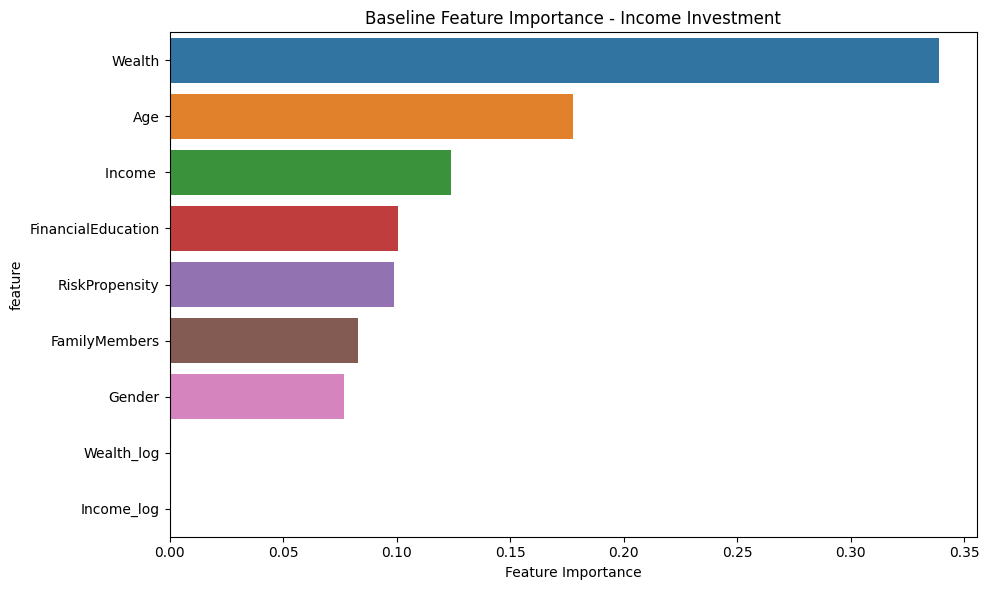

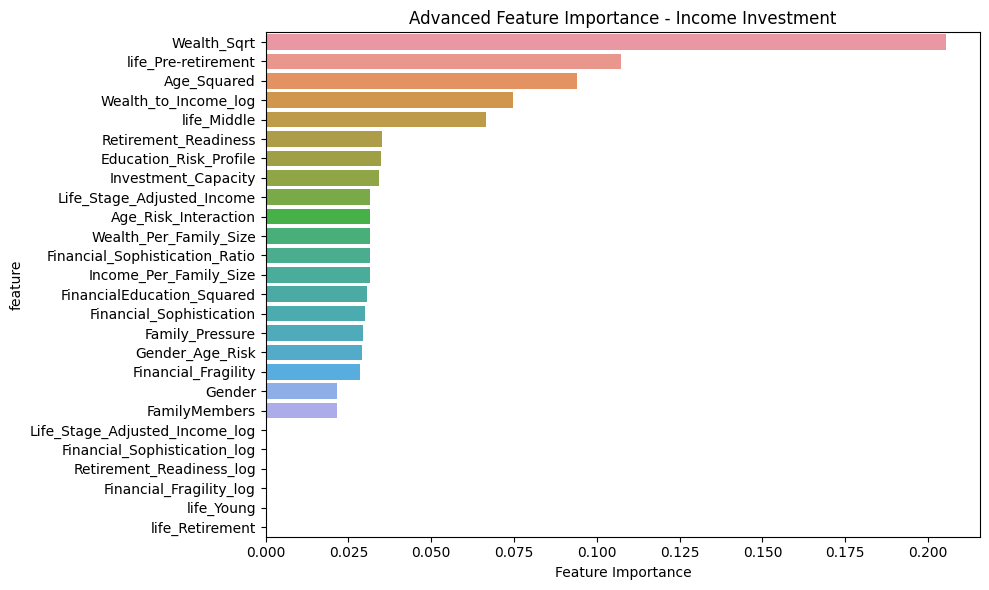


Feature Importance for Accumulation Investment


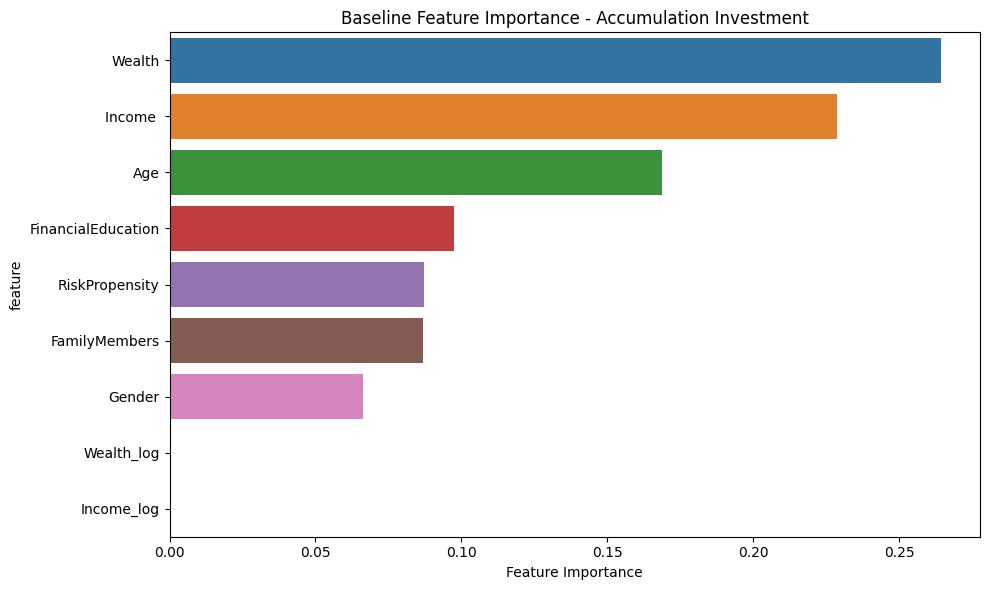

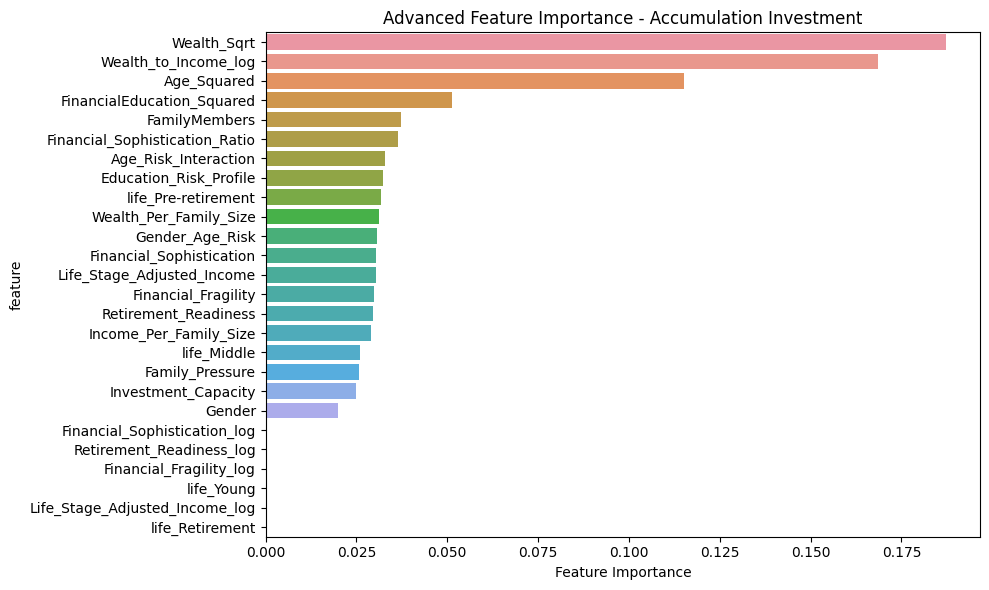

In [10]:
# Update the train_evaluate_model function to return the trained model
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        },
        'model': model
    }

# Feature importance function
def plot_feature_importance(model, feature_names, title):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

# Define XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')

# Run analysis and plot feature importance
for target_name, baseline_y, engineered_y in [
    ('Income Investment', baseline_y_income, engineered_y_income), 
    ('Accumulation Investment', baseline_y_accum, engineered_y_accum)
]:
    print(f"\nFeature Importance for {target_name}")
    print("=" * 50)
    
    # Baseline features
    baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = split_data(baseline_X, baseline_y)
    baseline_results = train_evaluate_model(
        baseline_X_train, baseline_y_train, 
        baseline_X_test, baseline_y_test, 
        xgb_model
    )
    plot_feature_importance(
        baseline_results['model'], 
        baseline_X.columns, 
        f'Baseline Feature Importance - {target_name}'
    )
    
    # Engineered features
    engineered_X_train, engineered_X_test, engineered_y_train, engineered_y_test = split_data(engineered_X, engineered_y)
    engineered_results = train_evaluate_model(
        engineered_X_train, engineered_y_train, 
        engineered_X_test, engineered_y_test, 
        xgb.XGBClassifier(random_state=42, eval_metric='logloss')  # Fresh model instance
    )
    plot_feature_importance(
        engineered_results['model'], 
        engineered_X.columns, 
        f'Advanced Feature Importance - {target_name}'
    )

## SHAP Values analysis

Shapley values, derived from Game Theory, provide a unified measure of feature importance that shows both the magnitude and direction of each feature's impact on model predictions. Unlike traditional feature importance, SHAP values reveal how each feature contributes positively or negatively to individual predictions. It's state-of-the-art XAI.

### Local and global interpretability: SHAP can do both
* **Local Analysis**: SHAP values explain individual predictions, showing how each feature contributed to a specific outcome.
* **Global Analysis**: Aggregating SHAP values across all predictions provides overall feature importance and interaction patterns.

### Implementation details
* Uses TreeExplainer, specifically designed for tree-based models like XGBoost
* Generates two complementary visualizations:
  * Bar plot of aggregated SHAP values, showing overall feature importance (global interpretation).
  * Summary plot showing feature impact distributions across all predictions  (combining local and global insights).
* Separate analysis for both investment needs using hold-out test data

This analysis should provides deeper insights into:
* Feature contribution magnitude.
* Direction of feature impacts
* Feature value **ranges** that most influence predictions
* Individual and population-level patterns

<br>




SHAP Analysis for Income Investment


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


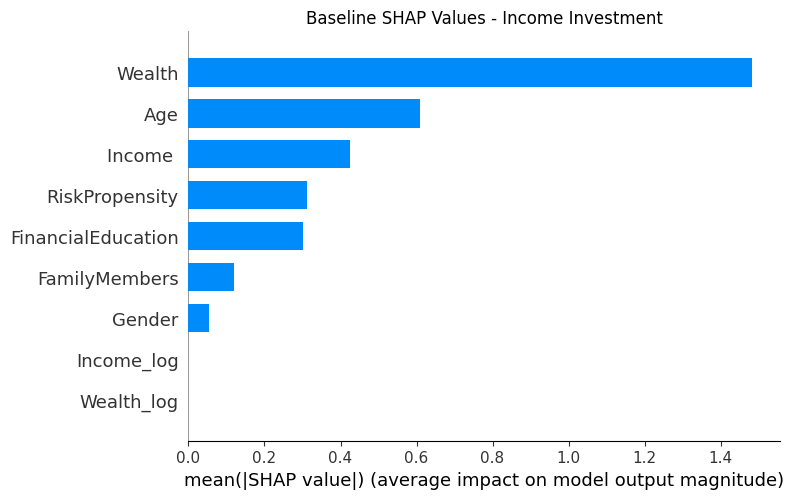

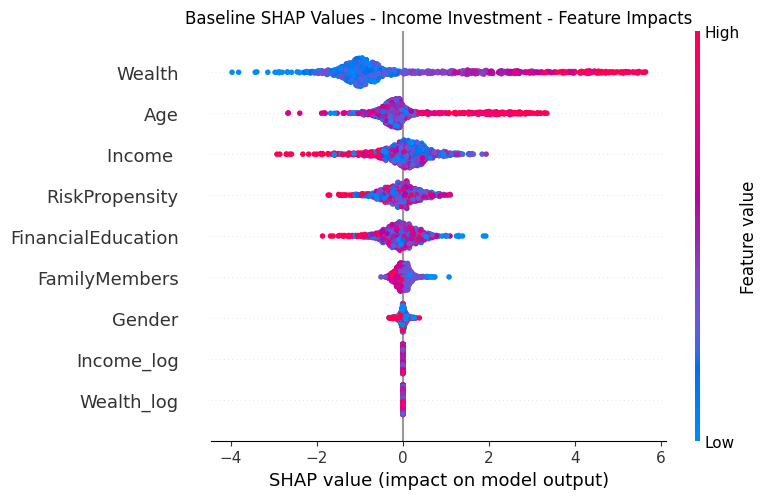

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


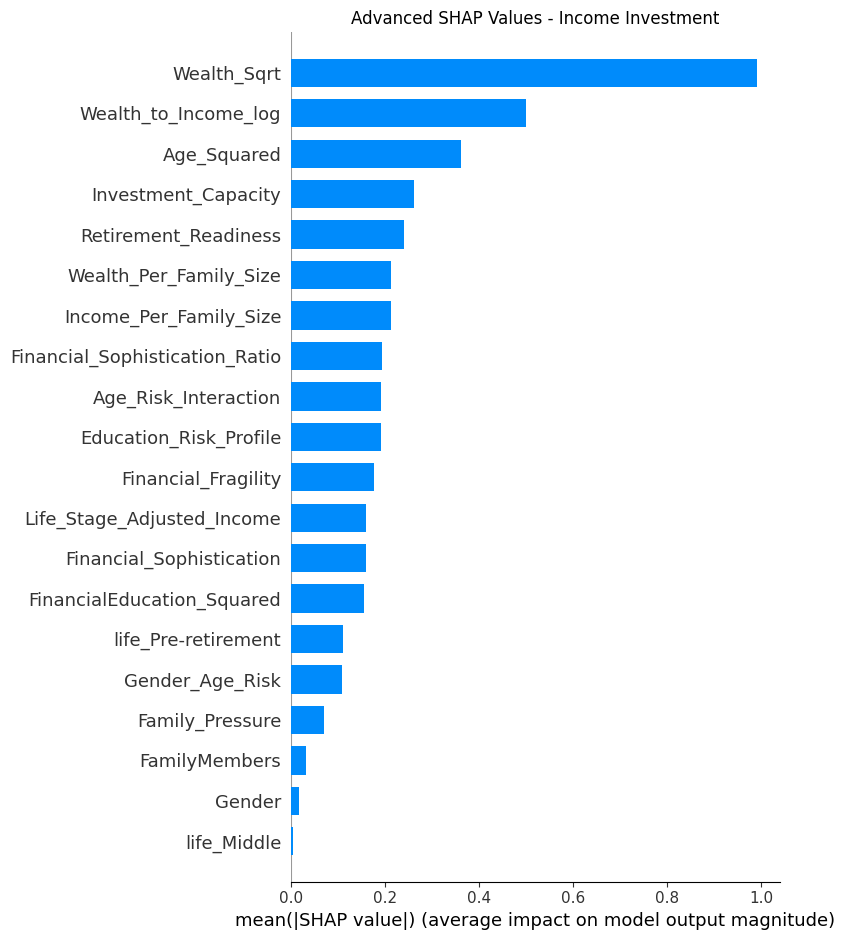

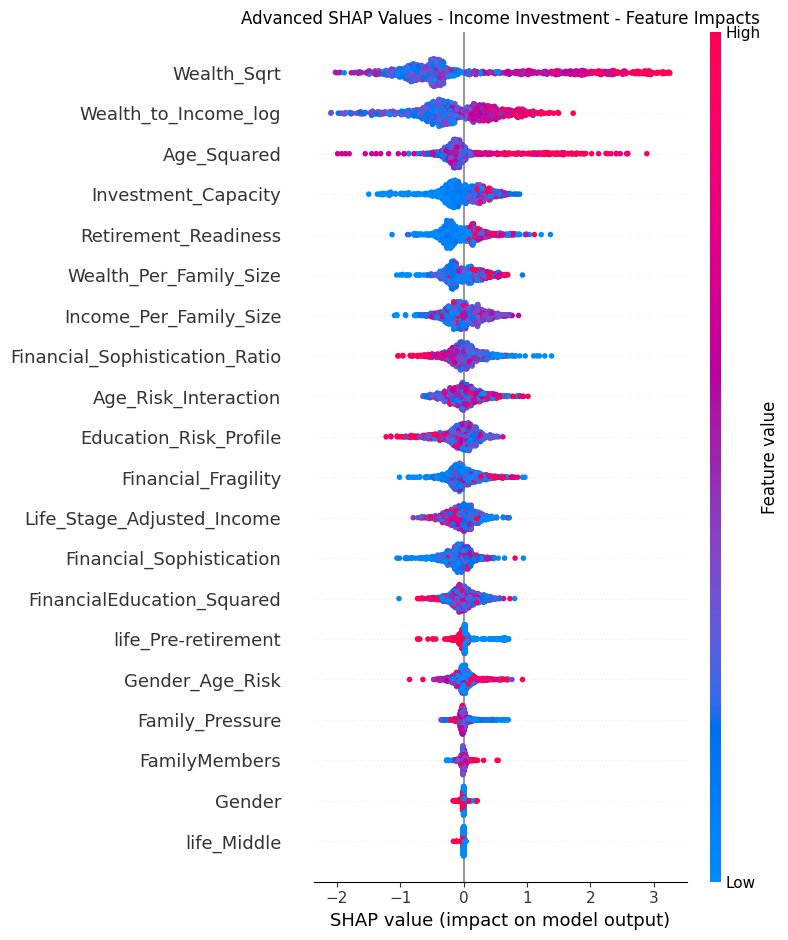


SHAP Analysis for Accumulation Investment


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


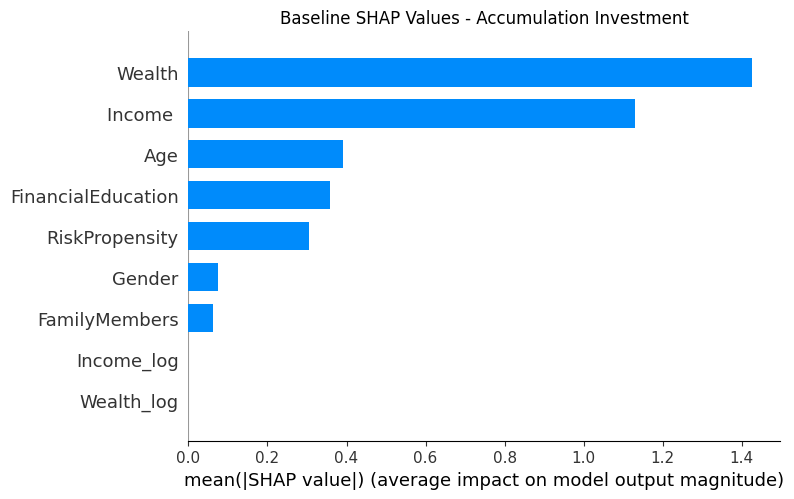

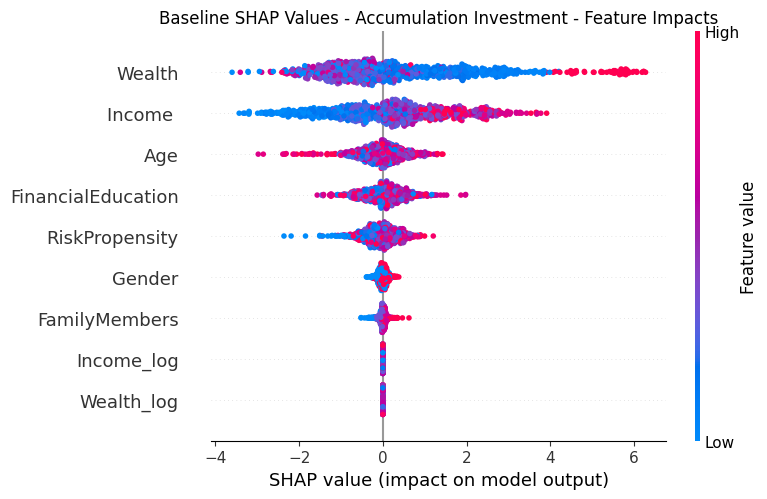

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


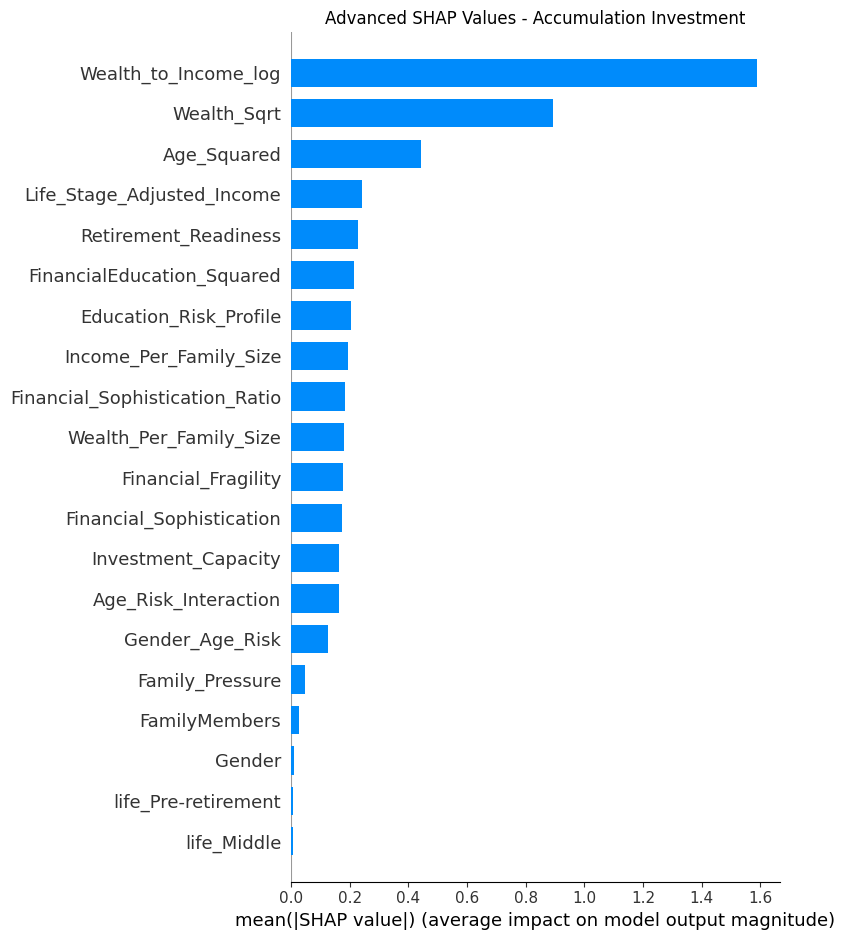

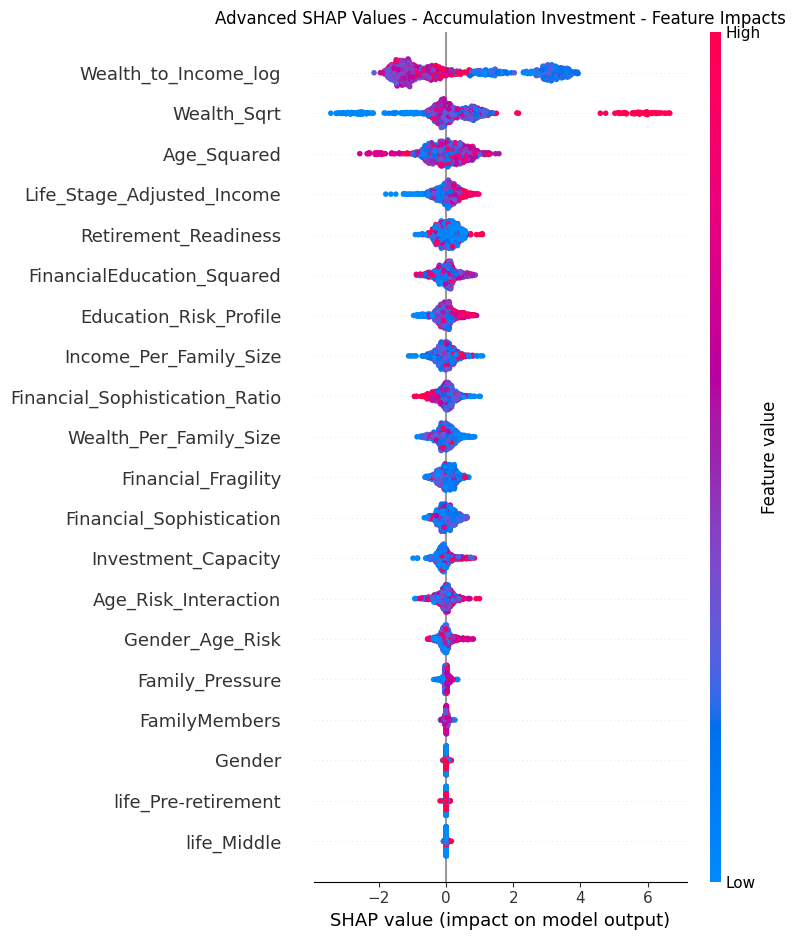

In [11]:
import shap

def plot_shap_values(model, X, title):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"{title} - Feature Impacts")
    plt.tight_layout()
    plt.show()

# Calculate and plot SHAP values for both targets and both feature sets
for target_name, baseline_y, engineered_y in [
    ('Income Investment', baseline_y_income, engineered_y_income), 
    ('Accumulation Investment', baseline_y_accum, engineered_y_accum)
]:
    print(f"\nSHAP Analysis for {target_name}")
    print("=" * 50)

    # Baseline features
    baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = split_data(baseline_X, baseline_y)
    baseline_results = train_evaluate_model(
        baseline_X_train, baseline_y_train, 
        baseline_X_test, baseline_y_test, 
        xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    )
    plot_shap_values(
        baseline_results['model'], 
        baseline_X_test, 
        f'Baseline SHAP Values - {target_name}'
    )
    
    # Engineered features
    engineered_X_train, engineered_X_test, engineered_y_train, engineered_y_test = split_data(engineered_X, engineered_y)
    engineered_results = train_evaluate_model(
        engineered_X_train, engineered_y_train, 
        engineered_X_test, engineered_y_test, 
        xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    )
    plot_shap_values(
        engineered_results['model'], 
        engineered_X_test, 
        f'Advanced SHAP Values - {target_name}'
    )

<br>

The results of Feature Importance analysis and SHAP seem overall quite comparable.

The alignment between feature importance and SHAP values reinforces our confidence in the model's interpretability. This consistency between different explanation methods validates our understanding of how features influence the predictions. It's particularly valuable to see both approaches highlighting similar key features, which strengthens our trust in the model's decision.


<br>

# **HINTs**

### **From the XAI side**

* Analyze the results carefully. And, for **local interpretability**, implement **individual SHAP prediction explanations** using:

```python
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])
```
    This will show how features contribute to specific individual predictions.

* **Additional interpretability methods** - Several other powerful methods can complement our current analysis:

1. LIME (Local Interpretable Model-agnostic Explanations)
   - Library: [`lime`](https://lime-ml.readthedocs.io/en/latest/).
   - Explains individual predictions through local approximation.

2. Permutation Importance
   - Library: [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html).
   - Measures feature importance through performance impact.

3. Partial Dependence Plots (PDP)
   - Library: [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) or [`pdpbox`](https://pdpbox.readthedocs.io/en/latest/).
   - Visualizes feature-target relationships

4. ICE (Individual Conditional Expectation) Plots
   - Library: [`pdpbox`](https://pdpbox.readthedocs.io/en/latest/).
   - Shows detailed feature impact on individual predictions.

### **From the modeling side**

* **Try other Boosting/Bagging models***
For example, **Random Forest**, a workhorse of Machine Learning that almost never denies decent results. Or use your imagination and curiosity...

* **Rank the models using rules**
Give yourself some rules to establish which models are better:
    * typically identify a **primary rule, or Optimizaion metric**, (e.g. "I want to optimize Recall") and **secondary rules, or Sufficiency Metrics**, very often more than one, for example "I want Precision higher than the minimum threshold of decency = X", "I want the training time to be a maximum of T seconds", etc.
    * **The choice of the primary rule, depends on the business context**. To understand it, **look at the Confusion Matrix** and think about what Accuracy, Precision, Recall, F1 are... but first read the following section.


 <br>

 ---

 <br>

# **Important digression: choosing the right validation metric: what really matters?**  

Which metric should we prioritize?  Each metric captures a different aspect of performance, and understanding their meaning is crucial:  

* **Accuracy**:
  * Measures **overall correctness**—the proportion of correctly classified customers.  
  * ⚠️ **Does not distinguish between errors** and performs **poorly on imbalanced data**.

* **Recall**:   
  * **Answers the question: "Out of all customers with Need X, how many did the model correctly identify?"**  
  * Useful when **missing true positives is costly** (e.g., detecting high-value prospects).

- **Precision**:  
  - **Answers the question: "Out of all customers predicted to have Need X, how many actually have it?"**  
  - Important when **false positives must be minimized** (e.g., avoiding irrelevant recommendations).

- **F1 Score**:  
  - **Harmonic mean of Precision and Recall**, balancing the trade-off between them.  
  - Ideal when both **false positives and false negatives matter**, or you are undecided...

Beyond these metrics:  
- **Lift**: Measures how much better the model is compared to random selection, useful in marketing and targeting.  
- **AUC-ROC / AUC-PR**: Assess **ranking performance** rather than just classification, critical in high-class imbalance settings.  

**Remember: No single metric is universally best.** The right choice depends on **business/practical objectives**. Think before choosing—metrics shape model behavior.


<br>

<br>

Now let's move to another class of models, a **Multilayer Perceptron (MLP) Neural Network (NN)**, a family of powerful and flexible models - and therefore at **risk of overfitting**.


## Multi-Layer Perceptron implementation

### NN architecture rationale
* **Decreasing Layer Sizes** (64 → 32 → 16 → 1): Creates a bottleneck architecture that forces the NN to learn increasingly compact representations (maybe reducing the risk of overfitting).
* **Batch Normalization**: Makes training of NN faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. [Batch Normalization](https://arxiv.org/abs/1502.03167) addresses internal covariate shift, particularly important with our mixed-scale financial features.
* **Dropout=0.2**: [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a light regularization that maintains most information while preventing co-adaptation. Basically, dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.
* **ReLU**: Provides non-linearity without gradient vanishing issues common in financial data modeling.
* **Sigmoid Output**: Transforms final layer output into probability scores for binary classification.

### Training configuration and reasoning
* **Binary Cross Entropy Loss**: Natural choice for binary classification with probabilistic interpretation
* **Adam Optimizer (lr=0.001)**: Adaptive learning rates help handle different feature scales.
* **Batch size=32**: Good balance between computational efficiency and gradient estimation.
* **100 epochs**: Sufficient iterations for convergence with validation monitoring every 10 epochs.

### Data handling
* Custom PyTorch Dataset class for efficient data loading.
* Separate training and evaluation pipelines.
* Comprehensive metrics evaluation (accuracy, precision, recall, F1), comparable to previous models.

<br>


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np

# Set up device for GPU acceleration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# MLP architecture
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Training function with enhanced logging
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Initialize tracking variables
    best_val_acc = 0
    train_losses = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    
    print(f"Starting training on {device}...")
    print(f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}")
    
    # Training loop with logging
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        batch_times = []
        
        print(f"Epoch {epoch+1}/{epochs} - Training...")
        for i, (X_batch, y_batch) in enumerate(train_loader):
            batch_start = time.time()
            
            # Move tensors to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item()
            batch_time = time.time() - batch_start
            batch_times.append(batch_time)
            
            # Print batch info occasionally
            if i % 5 == 0:
                print(f"  Batch {i+1}/{len(train_loader)}: loss={loss.item():.4f}, time={batch_time*1000:.1f}ms", end="\r")
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        
        print(f"\nEpoch {epoch+1}/{epochs} - Validating...")
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move tensors to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                
                # Move back to CPU for numpy conversion
                val_preds.extend((y_pred > 0.5).float().cpu().numpy())
                val_true.extend(y_batch.cpu().numpy())
        
        # Calculate metrics
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        val_acc = accuracy_score(val_true, val_preds)
        val_accs.append(val_acc)
        
        val_precision = precision_score(val_true, val_preds, zero_division=0)
        val_recall = recall_score(val_true, val_preds, zero_division=0)
        val_f1 = f1_score(val_true, val_preds, zero_division=0)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            improvement = "✓ (New Best)"
        else:
            improvement = ""
        
        # Log every epoch
        epoch_time = time.time() - start_time
        time_per_epoch = epoch_time / (epoch + 1)
        estimated_remaining = time_per_epoch * (epochs - epoch - 1)
        
        print(f"\nEpoch {epoch+1}/{epochs} - {epoch_time/60:.2f}m elapsed - {estimated_remaining/60:.2f}m remaining")
        print(f"  Train Loss: {avg_train_loss:.4f} | Batch Time: {np.mean(batch_times)*1000:.2f}ms")
        print(f"  Val Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f} {improvement}")
        print(f"  Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        
        # More detailed logs every 10 epochs or for final epoch
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
            pos_count = sum(val_true)
            neg_count = len(val_true) - pos_count
            print(f"  Class Distribution - Positive: {pos_count} ({pos_count/len(val_true)*100:.1f}%) | Negative: {neg_count} ({neg_count/len(val_true)*100:.1f}%)")
            
            # GPU info if available
            if device.type == "mps":
                print(f"  Using M4 Max GPU | PyTorch Version: {torch.__version__}")
    
    print(f"\nTraining completed in {(time.time() - start_time)/60:.2f} minutes")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'training_time': time.time() - start_time
    }

# Evaluation function for final metrics
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            # Move input to the same device as the model
            X_batch = X_batch.to(device)
            y_batch_cpu = y_batch.clone()  # Keep a CPU copy for metrics
            
            # Forward pass
            y_pred = model(X_batch).squeeze()
            
            # Move predictions back to CPU for numpy conversion
            all_preds.extend((y_pred > 0.5).float().cpu().numpy())
            all_true.extend(y_batch_cpu.numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Train neural networks on both baseline and engineered datasets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nTraining Neural Network on {dataset_name} Dataset for {target_name}")
        print("=" * 70)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize model, criterion, optimizer and move model to GPU
        model = MLP(input_size=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model with enhanced logging
        training_history = train_model(model, train_loader, test_loader, criterion, optimizer)
        
        # After training, evaluate on test set with the fixed evaluation function
        test_metrics = evaluate_nn_metrics(model, test_loader)
        
        print(f"\nFinal Test Results for {dataset_name} - {target_name}:")
        print(f"Accuracy: {test_metrics['accuracy']:.4f}")
        print(f"Precision: {test_metrics['precision']:.4f}")
        print(f"Recall: {test_metrics['recall']:.4f}")
        print(f"F1 Score: {test_metrics['f1']:.4f}")

Using device: mps

Training Neural Network on Baseline Dataset for Income Investment
Starting training on mps...
Training samples: 4000, Validation samples: 1000
Epoch 1/100 - Training...
  Batch 121/125: loss=0.6125, time=4.1ms
Epoch 1/100 - Validating...

Epoch 1/100 - 0.01m elapsed - 1.38m remaining
  Train Loss: 0.6238 | Batch Time: 5.86ms
  Val Loss: 0.5759 | Accuracy: 0.7300 ✓ (New Best)
  Precision: 0.7298 | Recall: 0.4714 | F1: 0.5728
Epoch 2/100 - Training...
  Batch 121/125: loss=0.6432, time=4.2ms
Epoch 2/100 - Validating...

Epoch 2/100 - 0.02m elapsed - 1.21m remaining
  Train Loss: 0.5578 | Batch Time: 4.65ms
  Val Loss: 0.5528 | Accuracy: 0.7460 ✓ (New Best)
  Precision: 0.7955 | Recall: 0.4557 | F1: 0.5795
Epoch 3/100 - Training...
  Batch 121/125: loss=0.5380, time=5.3ms
Epoch 3/100 - Validating...

Epoch 3/100 - 0.04m elapsed - 1.19m remaining
  Train Loss: 0.5377 | Batch Time: 5.27ms
  Val Loss: 0.5444 | Accuracy: 0.7520 ✓ (New Best)
  Precision: 0.8208 | Recall: 0.4

In [13]:
# Model evaluation with GPU support and enhanced printing
def evaluate_nn_metrics(model, data_loader):
    # Get the device the model is on
    device = next(model.parameters()).device
    print(f"Evaluating model on device: {device}")
    
    model.eval()
    all_preds = []
    all_true = []

    print("Starting evaluation...")
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(data_loader):
            # Keep original y_batch on CPU for metrics
            y_batch_cpu = y_batch.clone()
            
            # Move input to the same device as the model
            X_batch = X_batch.to(device)
            
            # Forward pass
            y_pred = model(X_batch).squeeze()
            
            # Move predictions back to CPU for numpy conversion
            all_preds.extend((y_pred > 0.5).float().cpu().numpy())
            all_true.extend(y_batch_cpu.numpy())
            
            # Print progress
            if i % 5 == 0:
                print(f"Processed {i+1}/{len(data_loader)} batches", end="\r")
    
    # Calculate metrics
    accuracy = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds)
    recall = recall_score(all_true, all_preds)
    f1 = f1_score(all_true, all_preds)
    
    print("\nEvaluation complete!")
    print(f"Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate and compare models on both datasets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nResults for {dataset_name} - {target_name}")
        print("=" * 50)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize new model for this dataset/target
        model = MLP(input_size=X_train.shape[1]).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model (using a shorter number of epochs for demonstration)
        training_history = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)

        print(f"\nEvaluating Training Set for {dataset_name} - {target_name}...")
        train_metrics = evaluate_nn_metrics(model, train_loader)
        
        print(f"\nEvaluating Test Set for {dataset_name} - {target_name}...")
        test_metrics = evaluate_nn_metrics(model, test_loader)

        # Display results
        print("\n==== Neural Network Performance Summary ====")
        metrics_df = pd.DataFrame({
            'Training': train_metrics,
            'Test': test_metrics
        }).round(3)

        print("\nNeural Network Metrics:")
        display(metrics_df)  # For Jupyter notebooks, better than print()
        
        # Also print as fallback in case display doesn't work
        print(f"\nTraining metrics: {train_metrics}")
        print(f"Test metrics: {test_metrics}")
        print("\n" + "="*50)


Results for Baseline - Income Investment
Starting training on mps...
Training samples: 4000, Validation samples: 1000
Epoch 1/50 - Training...
  Batch 121/125: loss=0.7041, time=4.2ms
Epoch 1/50 - Validating...

Epoch 1/50 - 0.01m elapsed - 0.46m remaining
  Train Loss: 0.6231 | Batch Time: 4.06ms
  Val Loss: 0.5871 | Accuracy: 0.7280 ✓ (New Best)
  Precision: 0.6892 | Recall: 0.5312 | F1: 0.6000
Epoch 2/50 - Training...
  Batch 121/125: loss=0.4641, time=4.2ms
Epoch 2/50 - Validating...

Epoch 2/50 - 0.02m elapsed - 0.46m remaining
  Train Loss: 0.5723 | Batch Time: 4.14ms
  Val Loss: 0.5611 | Accuracy: 0.7480 ✓ (New Best)
  Precision: 0.7519 | Recall: 0.5130 | F1: 0.6099
Epoch 3/50 - Training...
  Batch 121/125: loss=0.4887, time=4.1ms
Epoch 3/50 - Validating...

Epoch 3/50 - 0.03m elapsed - 0.45m remaining
  Train Loss: 0.5520 | Batch Time: 4.12ms
  Val Loss: 0.5517 | Accuracy: 0.7450 
  Precision: 0.7676 | Recall: 0.4818 | F1: 0.5920
Epoch 4/50 - Training...
  Batch 121/125: loss=

,Training,Test
accuracy,0.810,0.762
precision,0.865,0.802
recall,0.597,0.505
f1,0.707,0.620



Training metrics: {'accuracy': 0.80975, 'precision': 0.8649669499527857, 'recall': 0.5971316818774446, 'f1': 0.7065175472425762}
Test metrics: {'accuracy': 0.762, 'precision': 0.8016528925619835, 'recall': 0.5052083333333334, 'f1': 0.6198083067092652}


Results for Baseline - Accumulation Investment
Starting training on mps...
Training samples: 4000, Validation samples: 1000
Epoch 1/50 - Training...
  Batch 121/125: loss=0.6456, time=4.0ms
Epoch 1/50 - Validating...

Epoch 1/50 - 0.01m elapsed - 0.46m remaining
  Train Loss: 0.6730 | Batch Time: 4.00ms
  Val Loss: 0.6488 | Accuracy: 0.6190 ✓ (New Best)
  Precision: 0.5919 | Recall: 0.8285 | F1: 0.6905
Epoch 2/50 - Training...
  Batch 121/125: loss=0.6395, time=4.1ms
Epoch 2/50 - Validating...

Epoch 2/50 - 0.02m elapsed - 0.45m remaining
  Train Loss: 0.6408 | Batch Time: 4.05ms
  Val Loss: 0.6412 | Accuracy: 0.6390 ✓ (New Best)
  Precision: 0.6121 | Recall: 0.8090 | F1: 0.6969
Epoch 3/50 - Training...
  Batch 121/125: loss=0.6400, ti

,Training,Test
accuracy,0.795,0.768
precision,0.894,0.850
recall,0.682,0.665
f1,0.774,0.746



Training metrics: {'accuracy': 0.79525, 'precision': 0.8939974457215837, 'recall': 0.6819288845591817, 'f1': 0.7736943907156673}
Test metrics: {'accuracy': 0.768, 'precision': 0.8503740648379052, 'recall': 0.6647173489278753, 'f1': 0.7461706783369804}


Results for Advanced Engineered - Income Investment
Starting training on mps...
Training samples: 4000, Validation samples: 1000
Epoch 1/50 - Training...
  Batch 121/125: loss=0.5390, time=4.0ms
Epoch 1/50 - Validating...

Epoch 1/50 - 0.01m elapsed - 0.45m remaining
  Train Loss: 0.6139 | Batch Time: 3.99ms
  Val Loss: 0.5789 | Accuracy: 0.7120 ✓ (New Best)
  Precision: 0.7182 | Recall: 0.4115 | F1: 0.5232
Epoch 2/50 - Training...
  Batch 121/125: loss=0.6900, time=4.0ms
Epoch 2/50 - Validating...

Epoch 2/50 - 0.02m elapsed - 0.45m remaining
  Train Loss: 0.5561 | Batch Time: 4.01ms
  Val Loss: 0.5568 | Accuracy: 0.7310 ✓ (New Best)
  Precision: 0.7406 | Recall: 0.4609 | F1: 0.5682
Epoch 3/50 - Training...
  Batch 121/125: loss=0.598

,Training,Test
accuracy,0.812,0.773
precision,0.867,0.823
recall,0.604,0.521
f1,0.712,0.638



Training metrics: {'accuracy': 0.8125, 'precision': 0.8670411985018727, 'recall': 0.6036505867014341, 'f1': 0.7117601844734819}
Test metrics: {'accuracy': 0.773, 'precision': 0.823045267489712, 'recall': 0.5208333333333334, 'f1': 0.6379585326953748}


Results for Advanced Engineered - Accumulation Investment
Starting training on mps...
Training samples: 4000, Validation samples: 1000
Epoch 1/50 - Training...
  Batch 121/125: loss=0.6203, time=4.0ms
Epoch 1/50 - Validating...

Epoch 1/50 - 0.01m elapsed - 0.46m remaining
  Train Loss: 0.6691 | Batch Time: 4.04ms
  Val Loss: 0.6205 | Accuracy: 0.6730 ✓ (New Best)
  Precision: 0.6453 | Recall: 0.8051 | F1: 0.7164
Epoch 2/50 - Training...
  Batch 121/125: loss=0.6139, time=4.1ms
Epoch 2/50 - Validating...

Epoch 2/50 - 0.02m elapsed - 0.45m remaining
  Train Loss: 0.6204 | Batch Time: 4.02ms
  Val Loss: 0.5926 | Accuracy: 0.7110 ✓ (New Best)
  Precision: 0.7066 | Recall: 0.7466 | F1: 0.7261
Epoch 3/50 - Training...
  Batch 121/125: loss=0

,Training,Test
accuracy,0.816,0.789
precision,0.905,0.853
recall,0.716,0.712
f1,0.799,0.776



Training metrics: {'accuracy': 0.8155, 'precision': 0.9051139864448552, 'recall': 0.7155382367267413, 'f1': 0.7992383025027203}
Test metrics: {'accuracy': 0.789, 'precision': 0.852803738317757, 'recall': 0.7115009746588694, 'f1': 0.77577045696068}



<br>

Good results, certainly not exceptional.

Let's take another small step forward and introduce an enhanced version that maintains the core architecture while adding more sophisticated training dynamics and monitoring capabilities.

## Enhanced MLP implementation with Learning Curves

### Key Enhancements
* **Learning rate scheduler**: Implements **ReduceLROnPlateau** for **adaptive learning rate adjustment** - it's a smart technique, look at [this paper](https://arxiv.org/abs/1506.01186) and [this other one](https://arxiv.org/abs/1803.09820):
  * Reduces learning rate by 50% after 10 epochs without improvement.
  * Helps overcome plateaus and fine-tune learning in later stages.

* **Performance monitoring**:
  * Tracks training and validation losses across epochs.
  * Monitors validation accuracy progression.
  * Stores metrics for visualization.

* **Visualization capabilities**:
  * Real-time learning curves display.
  * Side-by-side loss and accuracy plots.
  * Visual assessment of model convergence and potential overfitting. Overfitting occurs when a model **performs well on training data but poorly on validation data**. In learning curves, this appears as:  
    * **Training loss decreasing steadily**.
    * **validation loss stops improving (plateaus) or increases** after a certain epoch.
    * A **large gap** between training and validation performance indicates overfitting, suggesting the need for **regularization, more data, or early stopping**.

The idea is you should:
- Experiment better convergence through **adaptive learning rates**.
- Get visual insights into training dynamics.
- Be able to identify overfitting/underfitting.
- Overall: More informed model evaluation.

<br>

In [14]:
# Enhanced MLP class
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Training with learning rate scheduler and visualization
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Move model to the appropriate device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    print(f"Training on device: {device}")
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().cpu().numpy())
                val_true.extend(y_batch.cpu().numpy())

        # Store metrics
        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(accuracy_score(val_true, val_preds))

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, '
                  f'Val Loss: {val_losses[-1]:.4f}, '
                  f'Val Accuracy: {val_accuracies[-1]:.4f}')

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model


Training Neural Network on Baseline Dataset for Income Investment
Training on device: mps
Epoch 10, Train Loss: 0.5263, Val Loss: 0.5340, Val Accuracy: 0.7620
Epoch 20, Train Loss: 0.5182, Val Loss: 0.5304, Val Accuracy: 0.7640
Epoch 30, Train Loss: 0.5003, Val Loss: 0.5284, Val Accuracy: 0.7650
Epoch 40, Train Loss: 0.5110, Val Loss: 0.5315, Val Accuracy: 0.7640
Epoch 50, Train Loss: 0.5071, Val Loss: 0.5283, Val Accuracy: 0.7580
Epoch 60, Train Loss: 0.5004, Val Loss: 0.5278, Val Accuracy: 0.7640
Epoch 70, Train Loss: 0.4994, Val Loss: 0.5265, Val Accuracy: 0.7620
Epoch 80, Train Loss: 0.5003, Val Loss: 0.5246, Val Accuracy: 0.7670
Epoch 90, Train Loss: 0.4982, Val Loss: 0.5257, Val Accuracy: 0.7630
Epoch 100, Train Loss: 0.4907, Val Loss: 0.5265, Val Accuracy: 0.7670


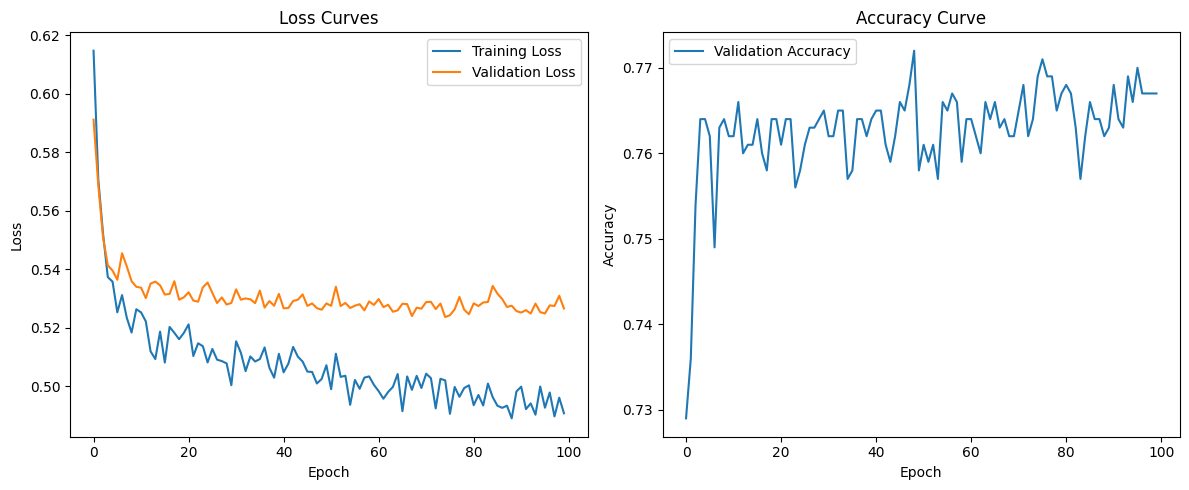


Results for Baseline - Income Investment
Evaluating model on device: mps:0
Starting evaluation...
Processed 121/125 batches
Evaluation complete!
Metrics - Accuracy: 0.8117, Precision: 0.8788, Recall: 0.5906, F1: 0.7064
Evaluating model on device: mps:0
Starting evaluation...
Processed 31/32 batches
Evaluation complete!
Metrics - Accuracy: 0.7670, Precision: 0.8297, Recall: 0.4948, F1: 0.6199

Neural Network Metrics:


,Training,Test
accuracy,0.812,0.767
precision,0.879,0.830
recall,0.591,0.495
f1,0.706,0.620



Training metrics: {'accuracy': 0.81175, 'precision': 0.8787584869059166, 'recall': 0.590612777053455, 'f1': 0.7064327485380117}
Test metrics: {'accuracy': 0.767, 'precision': 0.8296943231441049, 'recall': 0.4947916666666667, 'f1': 0.6199021207177815}


Training Neural Network on Baseline Dataset for Accumulation Investment
Training on device: mps
Epoch 10, Train Loss: 0.5449, Val Loss: 0.5340, Val Accuracy: 0.7250
Epoch 20, Train Loss: 0.5252, Val Loss: 0.5005, Val Accuracy: 0.7440
Epoch 30, Train Loss: 0.5170, Val Loss: 0.4825, Val Accuracy: 0.7730
Epoch 40, Train Loss: 0.5014, Val Loss: 0.4798, Val Accuracy: 0.7720
Epoch 50, Train Loss: 0.4989, Val Loss: 0.4651, Val Accuracy: 0.7900
Epoch 60, Train Loss: 0.5067, Val Loss: 0.4765, Val Accuracy: 0.7640
Epoch 70, Train Loss: 0.4925, Val Loss: 0.4611, Val Accuracy: 0.7830
Epoch 80, Train Loss: 0.4972, Val Loss: 0.4635, Val Accuracy: 0.7870
Epoch 90, Train Loss: 0.4837, Val Loss: 0.4658, Val Accuracy: 0.7900
Epoch 100, Train Loss: 0.4875

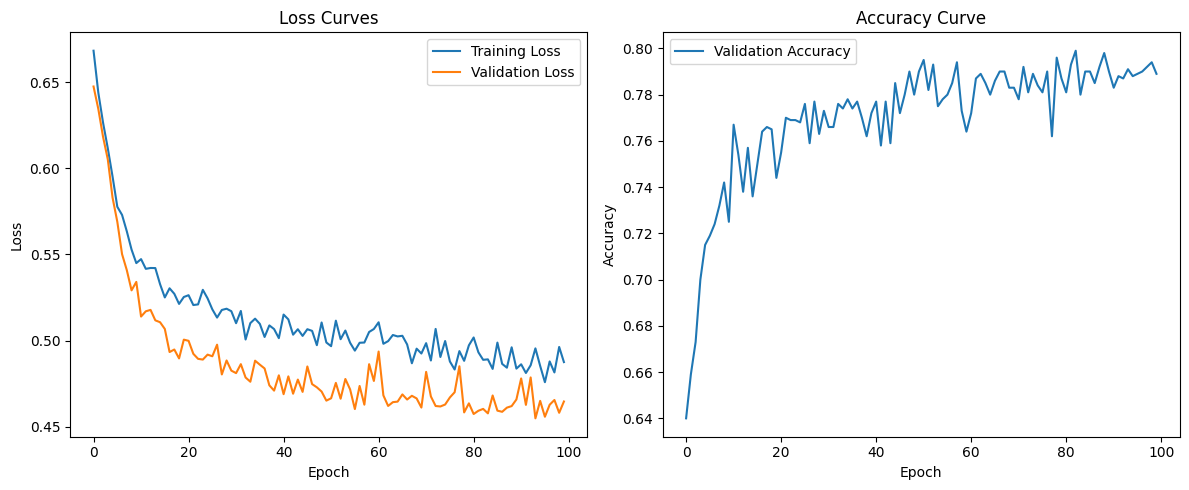


Results for Baseline - Accumulation Investment
Evaluating model on device: mps:0
Starting evaluation...
Processed 121/125 batches
Evaluation complete!
Metrics - Accuracy: 0.8170, Precision: 0.9199, Recall: 0.7048, F1: 0.7981
Evaluating model on device: mps:0
Starting evaluation...
Processed 31/32 batches
Evaluation complete!
Metrics - Accuracy: 0.7890, Precision: 0.8647, Recall: 0.6979, F1: 0.7724

Neural Network Metrics:


,Training,Test
accuracy,0.817,0.789
precision,0.920,0.865
recall,0.705,0.698
f1,0.798,0.772



Training metrics: {'accuracy': 0.817, 'precision': 0.9198982835346472, 'recall': 0.7048222113979542, 'f1': 0.7981246552675123}
Test metrics: {'accuracy': 0.789, 'precision': 0.8647342995169082, 'recall': 0.6978557504873294, 'f1': 0.7723840345199569}


Training Neural Network on Advanced Engineered Dataset for Income Investment
Training on device: mps
Epoch 10, Train Loss: 0.4972, Val Loss: 0.5164, Val Accuracy: 0.7650
Epoch 20, Train Loss: 0.4993, Val Loss: 0.5150, Val Accuracy: 0.7680
Epoch 30, Train Loss: 0.4881, Val Loss: 0.5117, Val Accuracy: 0.7710
Epoch 40, Train Loss: 0.4723, Val Loss: 0.5101, Val Accuracy: 0.7730
Epoch 50, Train Loss: 0.4806, Val Loss: 0.5133, Val Accuracy: 0.7720
Epoch 60, Train Loss: 0.4852, Val Loss: 0.5102, Val Accuracy: 0.7730
Epoch 70, Train Loss: 0.4838, Val Loss: 0.5118, Val Accuracy: 0.7740
Epoch 80, Train Loss: 0.4705, Val Loss: 0.5091, Val Accuracy: 0.7740
Epoch 90, Train Loss: 0.4625, Val Loss: 0.5107, Val Accuracy: 0.7760
Epoch 100, Train Loss: 0.

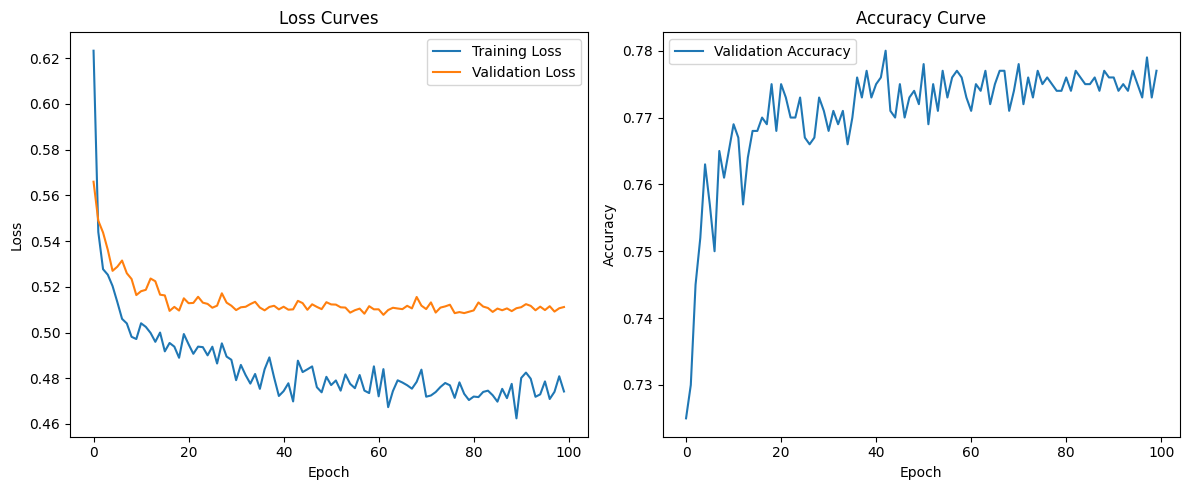


Results for Advanced Engineered - Income Investment
Evaluating model on device: mps:0
Starting evaluation...
Processed 121/125 batches
Evaluation complete!
Metrics - Accuracy: 0.8207, Precision: 0.8887, Recall: 0.6089, F1: 0.7226
Evaluating model on device: mps:0
Starting evaluation...
Processed 31/32 batches
Evaluation complete!
Metrics - Accuracy: 0.7770, Precision: 0.8397, Recall: 0.5182, F1: 0.6409

Neural Network Metrics:


,Training,Test
accuracy,0.821,0.777
precision,0.889,0.840
recall,0.609,0.518
f1,0.723,0.641



Training metrics: {'accuracy': 0.82075, 'precision': 0.8886774500475737, 'recall': 0.6088657105606258, 'f1': 0.7226305609284333}
Test metrics: {'accuracy': 0.777, 'precision': 0.8396624472573839, 'recall': 0.5182291666666666, 'f1': 0.6409017713365538}


Training Neural Network on Advanced Engineered Dataset for Accumulation Investment
Training on device: mps
Epoch 10, Train Loss: 0.5447, Val Loss: 0.5041, Val Accuracy: 0.7720
Epoch 20, Train Loss: 0.5110, Val Loss: 0.4805, Val Accuracy: 0.7830
Epoch 30, Train Loss: 0.5085, Val Loss: 0.4747, Val Accuracy: 0.7800
Epoch 40, Train Loss: 0.5055, Val Loss: 0.4685, Val Accuracy: 0.7880
Epoch 50, Train Loss: 0.5116, Val Loss: 0.4708, Val Accuracy: 0.7910
Epoch 60, Train Loss: 0.4828, Val Loss: 0.4685, Val Accuracy: 0.7820
Epoch 70, Train Loss: 0.4818, Val Loss: 0.4692, Val Accuracy: 0.7870
Epoch 80, Train Loss: 0.4722, Val Loss: 0.4633, Val Accuracy: 0.7850
Epoch 90, Train Loss: 0.4670, Val Loss: 0.4718, Val Accuracy: 0.7700
Epoch 100, Train 

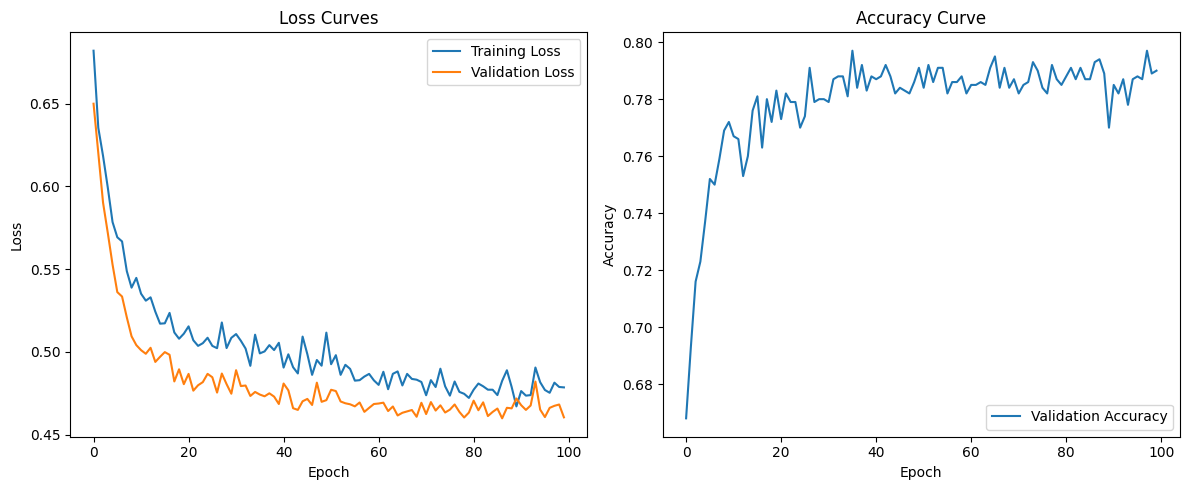


Results for Advanced Engineered - Accumulation Investment
Evaluating model on device: mps:0
Starting evaluation...
Processed 121/125 batches
Evaluation complete!
Metrics - Accuracy: 0.8260, Precision: 0.9070, Recall: 0.7365, F1: 0.8129
Evaluating model on device: mps:0
Starting evaluation...
Processed 31/32 batches
Evaluation complete!
Metrics - Accuracy: 0.7900, Precision: 0.8467, Recall: 0.7212, F1: 0.7789

Neural Network Metrics:


,Training,Test
accuracy,0.826,0.790
precision,0.907,0.847
recall,0.736,0.721
f1,0.813,0.779



Training metrics: {'accuracy': 0.826, 'precision': 0.9070185962807439, 'recall': 0.7364831953239163, 'f1': 0.8129032258064517}
Test metrics: {'accuracy': 0.79, 'precision': 0.8466819221967964, 'recall': 0.7212475633528265, 'f1': 0.7789473684210526}



In [15]:
# Training and evaluation for both datasets and both targets
for dataset_name, X, target_data in [
    ('Baseline', baseline_X, [(baseline_y_income, 'Income Investment'), (baseline_y_accum, 'Accumulation Investment')]),
    ('Advanced Engineered', engineered_X, [(engineered_y_income, 'Income Investment'), (engineered_y_accum, 'Accumulation Investment')])
]:
    for y, target_name in target_data:
        print(f"\nTraining Neural Network on {dataset_name} Dataset for {target_name}")
        print("=" * 70)

        # Split data
        X_train, X_test, y_train, y_test = split_data(X, y)

        # Create data loaders
        train_dataset = InvestmentDataset(X_train, y_train)
        test_dataset = InvestmentDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32)

        # Initialize model, criterion, optimizer
        model = MLP(input_size=X_train.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model with learning curves
        model = train_model_with_curves(model, train_loader, test_loader, criterion, optimizer)

        # Display final metrics
        print(f"\nResults for {dataset_name} - {target_name}")
        print("=" * 50)

        train_metrics = evaluate_nn_metrics(model, train_loader)
        test_metrics = evaluate_nn_metrics(model, test_loader)

        metrics_df = pd.DataFrame({
            'Training': train_metrics,
            'Test': test_metrics
        }).round(3)

        print("\nNeural Network Metrics:")
        display(metrics_df)  # For Jupyter notebooks
        
        # Also print as fallback
        print(f"\nTraining metrics: {train_metrics}")
        print(f"Test metrics: {test_metrics}")
        print("\n" + "="*50)

<br>

Short comment: these are rather strong results! The batch normalization and learning rate scheduler have improved the model's performance significantly. These results are competitive with XGBoost (particularly for Accumulation Investment prediction).

<br>

As you can see, thinking about the **NN architechture**, and **hyperparameter tuning** - broadly speaking, all aspects of the network architecture that can be changed are considered hyperparameters - can provide **significant improvements**.

<br>

# Personalized investment recommendations

## Overview

In the end, in this section, we'll implement a personalized recommendation system for investment products based on client characteristics and risk profiles. The recommendation process follows these key steps:

1. **Model implementation**: We'll use one of the best-performing models (the last one, i.e., the enhanced MLP neural network) to **identify clients with accumulation investment needs**. The other need and the other recommendation are up to you 😉.

2. **Client-product matching**: For each identified client, we'll match them with suitable accumulation products based on their risk tolerance. The matching algorithm selects the product with the highest risk level that remains below the client's risk propensity. You can also use other customer-product matching logics, this is just one...

3. **Recommendation analysis**: We'll analyze the distribution of recommendations across the client base, visualize the risk matching effectiveness, and identify the most frequently recommended products.

This approach demonstrates how predictive analytics can support financial advisors in making personalized product recommendations that balance potential returns with individual risk profiles.

Hera are some fairly obvious considerations. The process we'll implement offers several advantages for wealth management practices, that is:
- **Personalization**: Each recommendation is tailored to the individual client's needs and risk profile.
- **Consistency**: The systematic approach ensures consistent advice across the client base.
- **Scalability**: The algorithm can process large numbers of clients efficiently.
- **Risk-appropriate matching**: Recommendations respect each client's risk tolerance boundaries.

Let's proceed with implementing each step of this recommendation system, (memento) focusing specifically on accumulation investment products.

<br>

## Step 1: Training the NN with optimal set-up for personalized recommendations

In this section, we'll train our enhanced MLP NN to identify clients with accumulation investment needs. This model will form the foundation of our recommendation system by accurately classifying which clients would benefit from accumulation investment products.

### Key Components:

1. **Enhanced dataset class**: We've improved the `InvestmentDatasetFixed` class to handle both PyTorch tensors and Pandas data structures, making it more flexible for various data inputs.

2. **Prediction function**: The `get_predictions_from_mlp` function extracts binary predictions from our NN, identifying clients with accumulation investment needs.

3. **Product filtering**: We're focusing only on **accumulation products (Type=1)** from our product database, as this is our target recommendation category. You will implement the recommender system for the other product.

4. **Model training**: We train the neural network using our enhanced training function that displays learning curves, allowing us to monitor the training process and check model convergence.

5. **Test set predictions**: Finally, we apply the trained model to predict which clients in our test set have accumulation investment needs, creating the foundation for our personalized recommendations. The **binary predictions (`y_pred`) will serve as our classifier to identify which clients should receive accumulation product recommendations in the next step.**

<br>



Preparing product recommendations
Income products: 4
Accumulation products: 7

Training final recommendation models

Training Income Investment model on engineered features
--------------------------------------------------
Training on device: mps
Epoch 10, Train Loss: 0.5030, Val Loss: 0.5255, Val Accuracy: 0.7570
Epoch 20, Train Loss: 0.4883, Val Loss: 0.5183, Val Accuracy: 0.7680
Epoch 30, Train Loss: 0.4839, Val Loss: 0.5166, Val Accuracy: 0.7690
Epoch 40, Train Loss: 0.4855, Val Loss: 0.5136, Val Accuracy: 0.7710
Epoch 50, Train Loss: 0.4821, Val Loss: 0.5162, Val Accuracy: 0.7730
Epoch 60, Train Loss: 0.4718, Val Loss: 0.5136, Val Accuracy: 0.7740
Epoch 70, Train Loss: 0.4715, Val Loss: 0.5159, Val Accuracy: 0.7710
Epoch 80, Train Loss: 0.4850, Val Loss: 0.5194, Val Accuracy: 0.7680
Epoch 90, Train Loss: 0.4768, Val Loss: 0.5123, Val Accuracy: 0.7760
Epoch 100, Train Loss: 0.4757, Val Loss: 0.5116, Val Accuracy: 0.7740


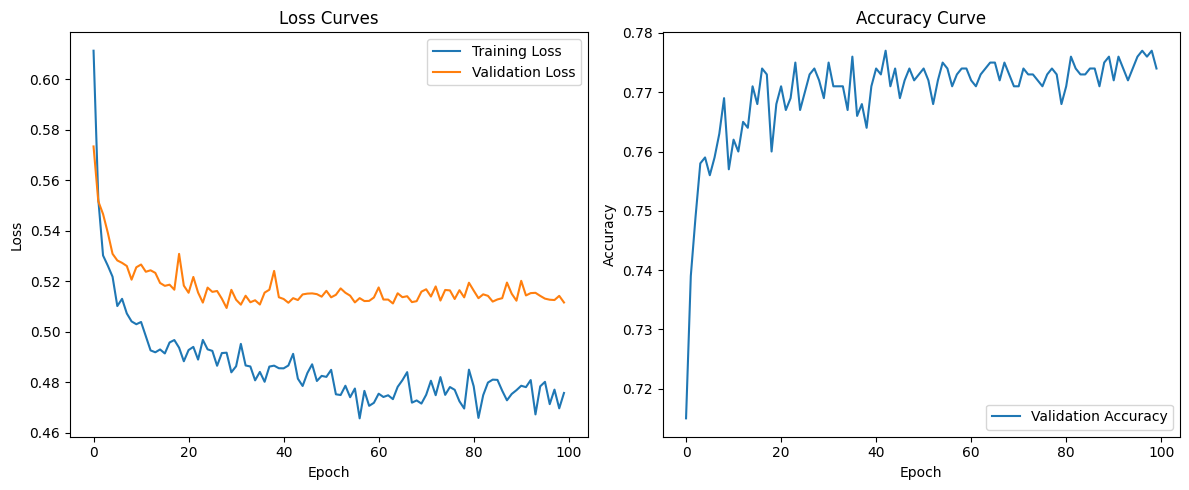


Training Accumulation Investment model on engineered features
--------------------------------------------------
Training on device: mps
Epoch 10, Train Loss: 0.5376, Val Loss: 0.5208, Val Accuracy: 0.7570
Epoch 20, Train Loss: 0.5227, Val Loss: 0.4984, Val Accuracy: 0.7570
Epoch 30, Train Loss: 0.5040, Val Loss: 0.4805, Val Accuracy: 0.7870
Epoch 40, Train Loss: 0.4854, Val Loss: 0.4742, Val Accuracy: 0.7770
Epoch 50, Train Loss: 0.4848, Val Loss: 0.4710, Val Accuracy: 0.7810
Epoch 60, Train Loss: 0.4780, Val Loss: 0.4571, Val Accuracy: 0.7820
Epoch 70, Train Loss: 0.4845, Val Loss: 0.4748, Val Accuracy: 0.7870
Epoch 80, Train Loss: 0.4697, Val Loss: 0.4687, Val Accuracy: 0.7840
Epoch 90, Train Loss: 0.4717, Val Loss: 0.4676, Val Accuracy: 0.7830
Epoch 100, Train Loss: 0.4690, Val Loss: 0.4550, Val Accuracy: 0.7820


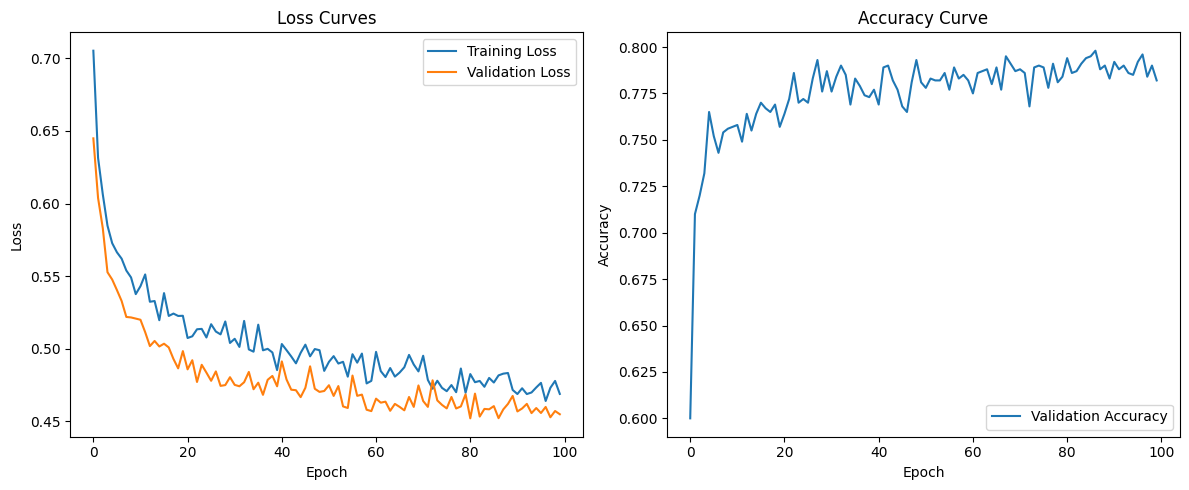


Generating predictions for all clients
Income investment predictions: 1269.0 positive out of 5000 (25.4%)
Accumulation investment predictions: 2158.0 positive out of 5000 (43.2%)


In [16]:
# Let's modify the Investment Dataset class to handle both Pandas and PyTorch
class InvestmentDatasetFixed(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        # Check if y is already a tensor or needs to be converted
        if isinstance(y, torch.Tensor):
            self.y = y
        else:
            self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Function to get predictions from the MLP model
def get_predictions_from_mlp(model, X_test, device=None):
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Create a dataset and dataloader for predictions
    dummy_y = pd.Series(np.zeros(len(X_test)))
    test_dataset = InvestmentDatasetFixed(X_test, dummy_y)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Get predictions
    model.eval()
    model = model.to(device)
    all_preds = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().cpu().numpy())

    return np.array(all_preds)

# Filtering products based on investment type
print("\nPreparing product recommendations")
print("=" * 80)

income_products = products_df[products_df['Type'] == 0].copy()
accumulation_products = products_df[products_df['Type'] == 1].copy()
print(f"Incomeproducts: {len(income_products)}")
print(f"Accumulation products: {len(accumulation_products)}")

# Train models for both types of investment using the engineered dataset
print("\nTraining final recommendation models")
print("=" * 80)

# Define common device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# For Income Investment prediction
print("\nTraining Income Investment model on engineered features")
print("-" * 50)

X_train, X_test, y_train, y_test = split_data(engineered_X, engineered_y_income)
train_dataset = InvestmentDatasetFixed(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = InvestmentDatasetFixed(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

income_model = MLP(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(income_model.parameters(), lr=0.001)
income_model = train_model_with_curves(income_model, train_loader, test_loader, criterion, optimizer)

# For Accumulation Investment prediction
print("\nTraining Accumulation Investment model on engineered features")
print("-" * 50)

X_train, X_test, y_train, y_test = split_data(engineered_X, engineered_y_accum)
train_dataset = InvestmentDatasetFixed(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = InvestmentDatasetFixed(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

accum_model = MLP(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(accum_model.parameters(), lr=0.001)
accum_model = train_model_with_curves(accum_model, train_loader, test_loader, criterion, optimizer)

# Get predictions for the entire dataset
print("\nGenerating predictions for all clients")
income_preds = get_predictions_from_mlp(income_model, engineered_X, device)
accum_preds = get_predictions_from_mlp(accum_model, engineered_X, device)

# Display predictions summary
print(f"Incomeinvestment predictions: {sum(income_preds)} positive out of {len(income_preds)} ({sum(income_preds)/len(income_preds)*100:.1f}%)")
print(f"Accumulation investment predictions: {sum(accum_preds)} positive out of {len(accum_preds)} ({sum(accum_preds)/len(accum_preds)*100:.1f}%)")


## Client-product matching based on risk profiles

In this section, we implement the core matching algorithm that pairs clients with appropriate investment products. Our approach focuses on risk-appropriate recommendations by matching each client's risk tolerance with suitable product risk levels.

### The matching algorithm explained:

Our recommendation approach follows a simple risk-optimized strategy:

1. **Target client identification**: We focus only on clients who have been predicted to need accumulation investment products by our neural network.

2. **Risk profile analysis**: For each target client, we extract their risk propensity score which indicates the maximum investment risk they can tolerate.

3. **Product filtering**: We identify all accumulation products with risk levels below the client's risk propensity (ensuring suitability from the regulatory point of view).

4. **Optimal selection**: From suitable products, we recommend the one with the highest risk level, maximizing potential returns while respecting risk boundaries.


The scatter plot shows the relationship between client risk propensity and recommended product risk levels. Points below the diagonal line represent conservative recommendations where product risk is lower than the client's risk tolerance.

This risk-optimized approach balances compliance with client protection regulations while seeking to maximize potential investment returns through appropriate risk exposure.

<br>



Generating Income Investment Recommendations
Using 'Age_Risk_Interaction' as the risk measure


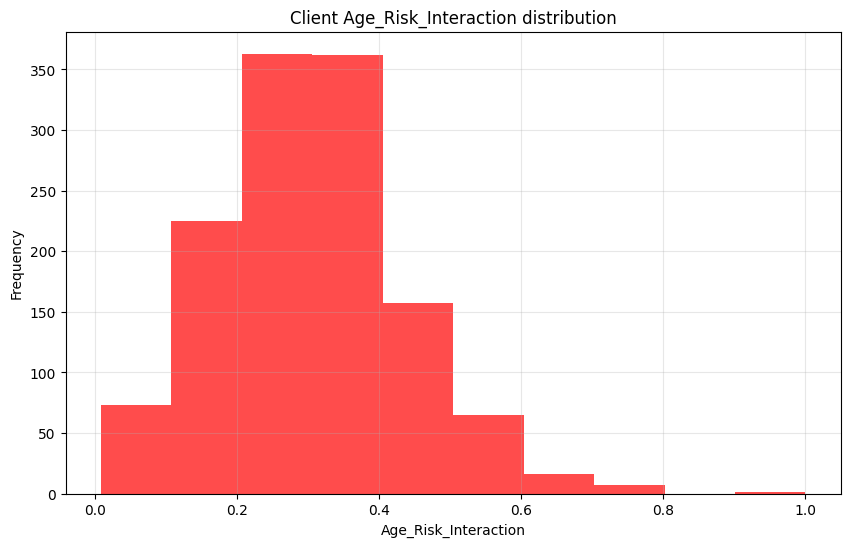


Generating Accumulation Investment Recommendations
Using 'Age_Risk_Interaction' as the risk measure


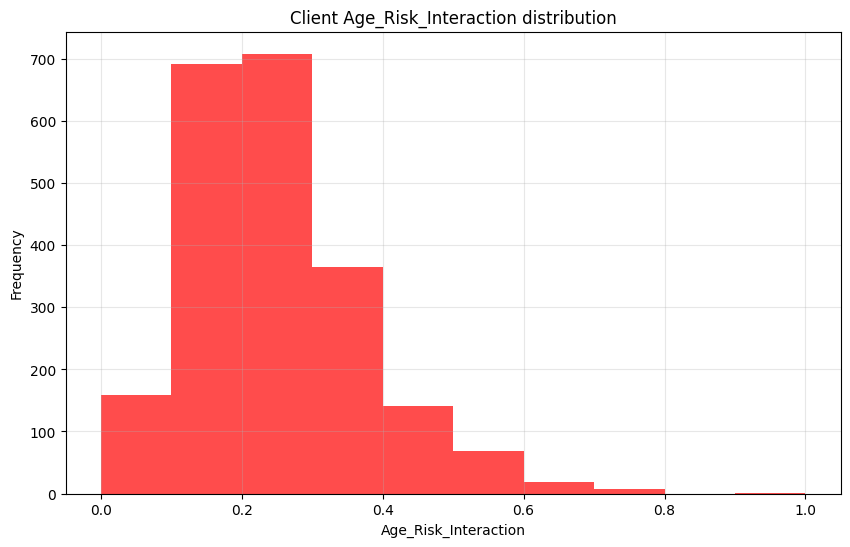


Top 5 Income Investment Recommendations:
   ClientID  RecommendedProductID  ClientRiskMeasure  ProductRiskLevel
0         1                    10           0.151736              0.13
1         3                     4           0.552388              0.44
2         8                    10           0.164906              0.13
3         9                     2           0.389794              0.30
4        11                     2           0.306579              0.30


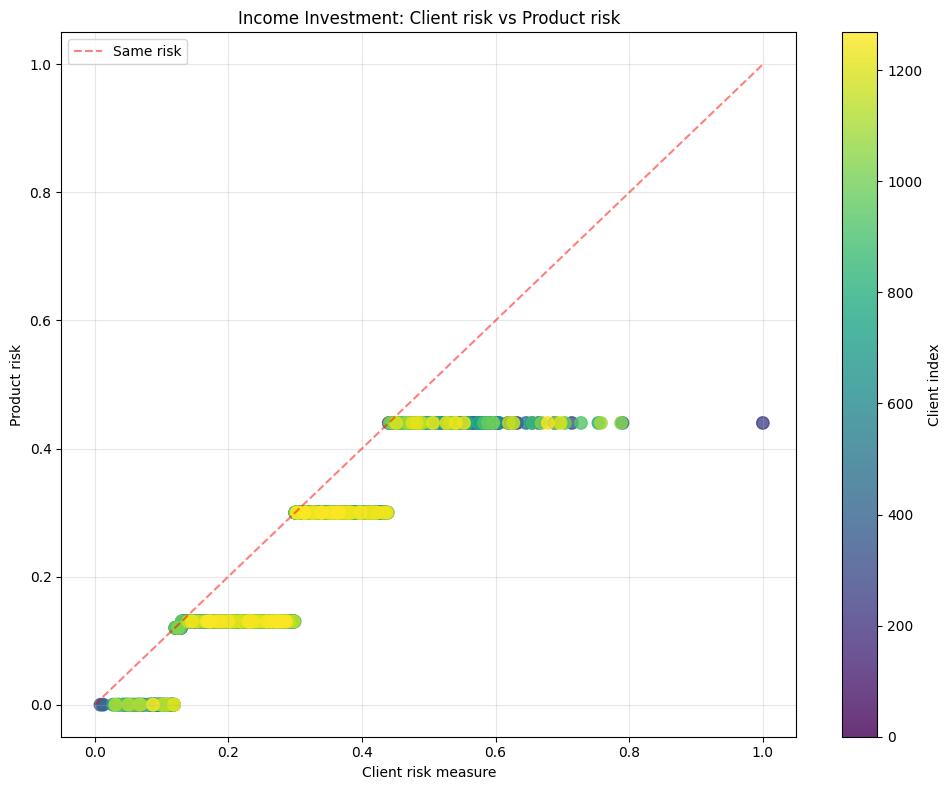


Top 5 Accumulation Investment Recommendations:
   ClientID  RecommendedProductID  ClientRiskMeasure  ProductRiskLevel
0         0                     0           0.160170              0.00
1         3                     1           0.552388              0.55
2         5                     0           0.255867              0.00
3         6                     0           0.221998              0.00
4         7                     0           0.144426              0.00


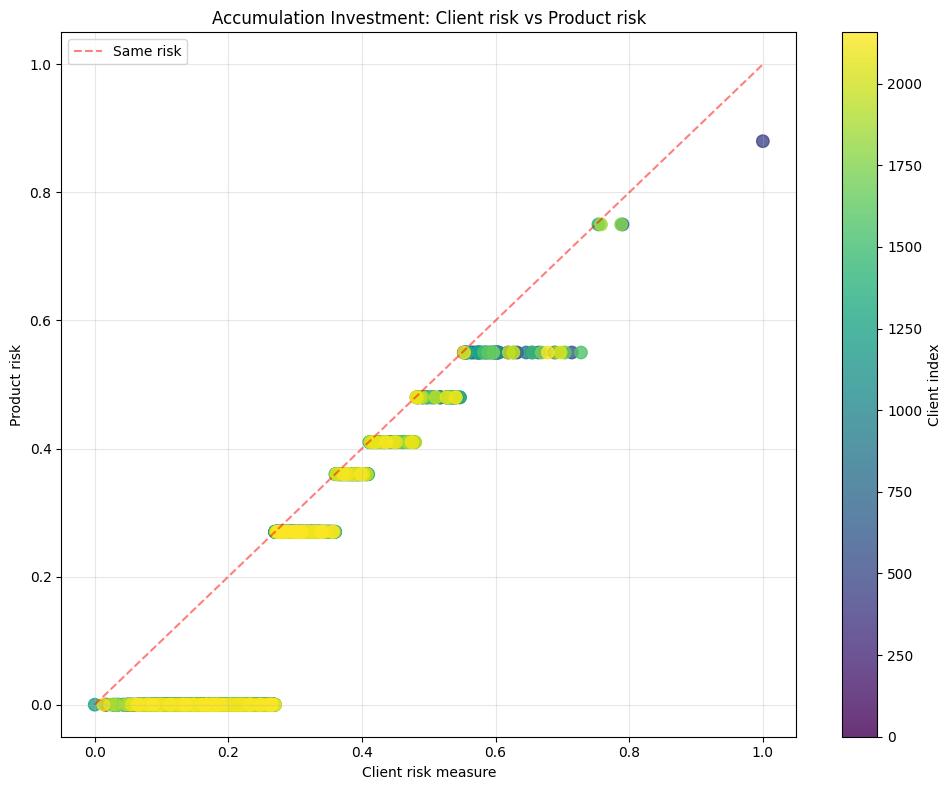


Recommendation Summary:
------------------------------
Total clients analyzed: 5000
Clients recommended for Income Investment: 1269 (25.4%)
Clients recommended for Accumulation Investment: 2158 (43.2%)


In [17]:
# Create recommendation function that can be applied to both investment types
def generate_recommendations(client_data, predictions, product_data, risk_column=None):
    # Check for an appropriate risk column
    if risk_column is None or risk_column not in client_data.columns:
        # Look for alternatives
        possible_risk_columns = [
            'RiskPropensity',
            'RiskPropensity_Squared',
            'Risk_Capacity',
            'Age_Risk_Interaction',
            'Education_Risk_Profile'
        ]
        
        for col in possible_risk_columns:
            if col in client_data.columns:
                risk_column = col
                print(f"Using '{risk_column}' as the risk measure")
                break
        
        # If we still don't have a risk column, use a default approach
        if risk_column is None or risk_column not in client_data.columns:
            print("No suitable risk column found. Using default risk value of 0.5")
            # Create a temporary column with default risk values
            client_data = client_data.copy()
            client_data['default_risk'] = 0.5
            risk_column = 'default_risk'
    
    # Filter clients predicted to need this investment type
    client_indices = np.where(predictions == 1)[0]
    if len(client_indices) == 0:
        print("No clients were predicted to need this investment type")
        return pd.DataFrame()
    
    target_client_ids = client_data.index[client_indices].values
    target_client_risk = client_data.iloc[client_indices][risk_column].values
    
    # Get minimum risk level from available products
    min_product_risk = product_data['Risk'].min()
    
    # Visualizing the risk propensity distribution of target clients
    plt.figure(figsize=(10, 6))
    plt.hist(target_client_risk, color='r', bins=10, alpha=0.7)
    plt.title(f'Client {risk_column} distribution')
    plt.xlabel(risk_column)
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()
    
    # Initialize lists to store recommendation results
    product_recommendations = []
    risk_levels = []
    
    # Extract product information for matching
    product_ids = product_data['IDProduct'].astype(np.uint16).values
    product_risks = product_data['Risk'].values
    
    # Generate personalized recommendations for each target client
    for client_risk in target_client_risk:
        if client_risk > min_product_risk:
            # Find products with acceptable risk (< customer's appetite)
            suitable_products = product_risks[product_risks < client_risk]
            
            if len(suitable_products) > 0:
                # Find the product with the highest risk among suitable ones
                max_suitable_risk = max(suitable_products)
                recommended_product_id = product_ids[product_risks == max_suitable_risk][0]
                product_recommendations.append(recommended_product_id)
                risk_levels.append(max_suitable_risk)
            else:
                # No suitable products
                product_recommendations.append(0)
                risk_levels.append(0)
        else:
            # Client's risk propensity too low for any available product
            product_recommendations.append(0)
            risk_levels.append(0)
    
    # Create a comprehensive recommendation matrix
    recommendations_df = pd.DataFrame({
        'ClientID': target_client_ids,
        'RecommendedProductID': product_recommendations,
        'ClientRiskMeasure': target_client_risk,
        'ProductRiskLevel': risk_levels
    })
    
    return recommendations_df

# Generate recommendations for both investment types
print("\nGenerating Income Investment Recommendations")
print("=" * 50)
income_recommendations = generate_recommendations(
    engineered_X, income_preds, 
    products_df[products_df['Type'] == 0]  # Incomeproducts (Type 0)
)

print("\nGenerating Accumulation Investment Recommendations")
print("=" * 50)
accumulation_recommendations = generate_recommendations(
    engineered_X, accum_preds, 
    products_df[products_df['Type'] == 1]  # Accumulation products (Type 1)
)

# Display sample recommendations
if not income_recommendations.empty:
    print("\nTop 5 Income Investment Recommendations:")
    print(income_recommendations.head(5))
    
    # Suitability Chart: customer risk measure vs product risk
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        income_recommendations['ClientRiskMeasure'],
        income_recommendations['ProductRiskLevel'],
        c=range(len(income_recommendations)),
        cmap='viridis',
        alpha=0.8,
        s=80
    )
    plt.colorbar(scatter, label='Client index')
    plt.title('Income Investment: Client risk vs Product risk')
    plt.xlabel('Client risk measure')
    plt.ylabel('Product risk')
    plt.grid(alpha=0.3)
    
    # Add reference line for perfect risk matching
    max_val = max(income_recommendations['ClientRiskMeasure'].max(), 
                  income_recommendations['ProductRiskLevel'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Same risk')
    plt.legend()
    plt.tight_layout()
    plt.show()

if not accumulation_recommendations.empty:
    print("\nTop 5 Accumulation Investment Recommendations:")
    print(accumulation_recommendations.head(5))
    
    # Suitability Chart
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        accumulation_recommendations['ClientRiskMeasure'],
        accumulation_recommendations['ProductRiskLevel'],
        c=range(len(accumulation_recommendations)),
        cmap='viridis',
        alpha=0.8,
        s=80
    )
    plt.colorbar(scatter, label='Client index')
    plt.title('Accumulation Investment: Client risk vs Product risk')
    plt.xlabel('Client risk measure')
    plt.ylabel('Product risk')
    plt.grid(alpha=0.3)
    
    # Add reference line for perfect risk matching
    max_val = max(accumulation_recommendations['ClientRiskMeasure'].max(), 
                  accumulation_recommendations['ProductRiskLevel'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label='Same risk')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Summary statistics
print("\nRecommendation Summary:")
print("-" * 30)
print(f"Total clients analyzed: {len(engineered_X)}")
print(f"Clients recommended for Income Investment: {len(income_recommendations)} ({len(income_recommendations)/len(engineered_X)*100:.1f}%)")
print(f"Clients recommended for Accumulation Investment: {len(accumulation_recommendations)} ({len(accumulation_recommendations)/len(engineered_X)*100:.1f}%)")

## Analyzing recommendation results

In this final section, we analyze the effectiveness and distribution of our personalized product recommendations. Just to understand. We'll examine how many clients received suitable recommendations, which products were most frequently recommended, and the underlying characteristics of those products.

1. **Coverage statistics**: We calculate what percentage of target clients received valid recommendations. Clients without recommendations represent either those with risk tolerance below any available product or those with special needs not met by the current product lineup.

2. **Product distribution**: The bar chart visualizes which products are most frequently recommended across our client base. This helps identify "best-selling" products and potential gaps in the product lineup.

3. **Top product analysis**: For the most frequently recommended products, we provide detailed risk characteristics. This information helps understand which risk levels are most relevant to the current client portfolio.

These analytics provide some insights to product development teams about potential adjustments to the product lineup, such as creating new products to address underserved risk profiles. A data-driven approach helps to understanding both the effectiveness of the recommendation system and the alignment between the client base and product offerings.

<br>


ANALYSIS OF INCOME INVESTMENT RECOMMENDATIONS

Income Investment Recommendation statistics:
Total customers analyzed: 1269
Customers with valid recommendations: 1178 (92.83%)
Customers without suitable recommendations: 91


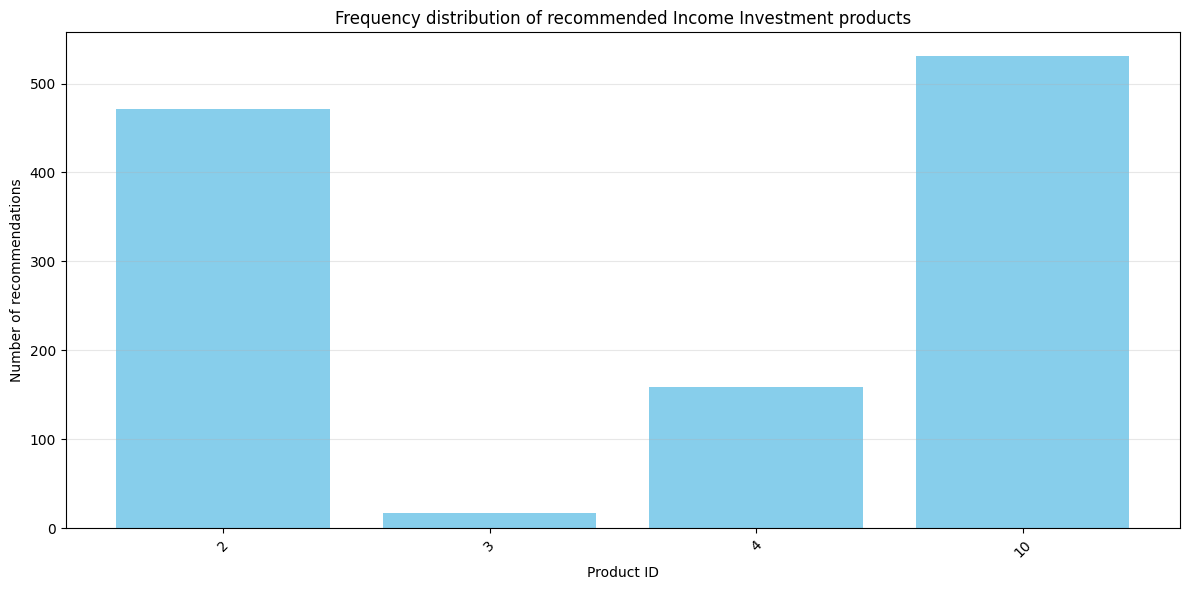


Details on the most recommended Income Investment products:

Product ID: 10
Risk: 0.13
Recommended to 531 clients

Product ID: 2
Risk: 0.3
Recommended to 471 clients

Product ID: 4
Risk: 0.44
Recommended to 159 clients

ANALYSIS OF ACCUMULATION INVESTMENT RECOMMENDATIONS

Accumulation Investment Recommendation statistics:
Total customers analyzed: 2158
Customers with valid recommendations: 784 (36.33%)
Customers without suitable recommendations: 1374


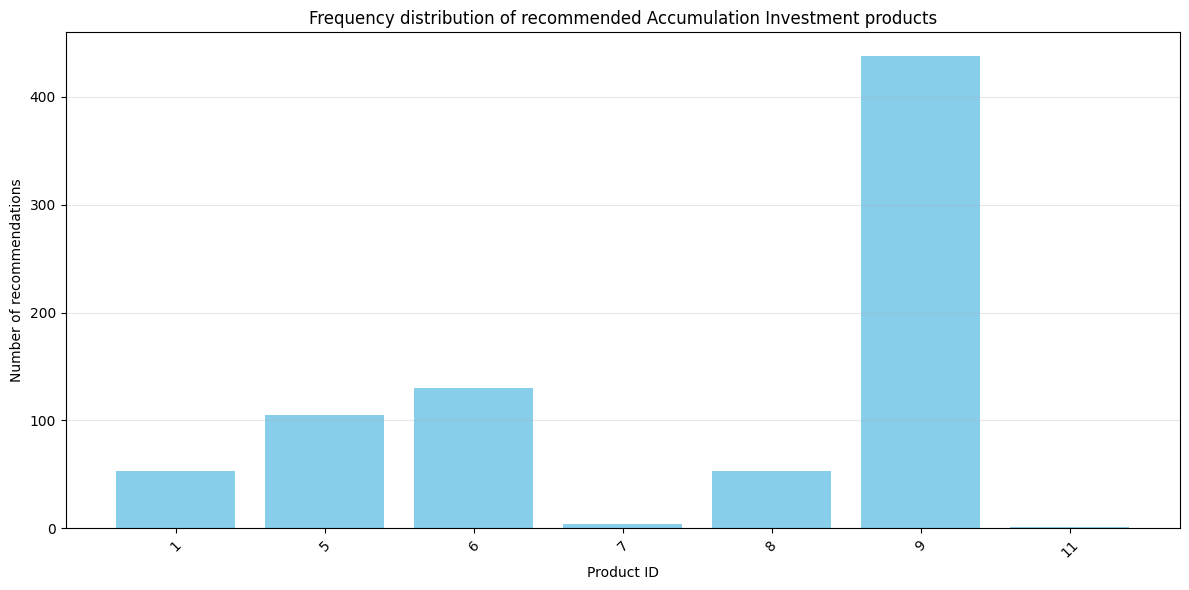


Details on the most recommended Accumulation Investment products:

Product ID: 9
Risk: 0.27
Recommended to 438 clients

Product ID: 6
Risk: 0.36
Recommended to 130 clients

Product ID: 5
Risk: 0.41
Recommended to 105 clients

OVERALL RECOMMENDATION COVERAGE
Total clients in dataset: 5000
Clients with any recommendation: 2871 (57.42%)
Clients with only Income recommendations: 713 (14.26%)
Clients with only Accumulation recommendations: 1602 (32.04%)
Clients with both types of recommendations: 556 (11.12%)
Clients with no recommendations: 2129 (42.58%)


In [18]:
# Function to analyze recommendations
def analyze_recommendations(recommendations_df, products_df, investment_type):
    if recommendations_df.empty:
        print(f"\nNo {investment_type} recommendations were generated.")
        return
    
    total_clients = len(recommendations_df)
    clients_with_recommendations = len(recommendations_df[recommendations_df['RecommendedProductID'] > 0])
    percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

    print(f"\n{investment_type} Recommendation statistics:")
    print(f"Total customers analyzed: {total_clients}")
    print(f"Customers with valid recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.2f}%)")
    print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations}")

    # Frequency distribution of recommended products
    if clients_with_recommendations > 0:
        plt.figure(figsize=(12, 6))

        # Recommended products
        recommendation_counts = recommendations_df['RecommendedProductID'].value_counts().sort_index()
        recommendation_counts = recommendation_counts[recommendation_counts.index > 0]  # Exclude ID 0

        plt.bar(recommendation_counts.index.astype(str), recommendation_counts.values, color='skyblue')
        plt.title(f'Frequency distribution of recommended {investment_type} products')
        plt.xlabel('Product ID')
        plt.ylabel('Number of recommendations')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Details on the most recommended products
        if len(recommendation_counts) > 0:
            top_products = recommendation_counts.nlargest(3).index
            print(f"\nDetails on the most recommended {investment_type} products:")
            for prod_id in top_products:
                product_details = products_df[products_df['IDProduct'] == prod_id]
                if not product_details.empty:
                    print(f"\nProduct ID: {prod_id}")
                    print(f"Risk: {product_details['Risk'].values[0]}")
                    print(f"Recommended to {recommendation_counts[prod_id]} clients")
    else:
        print(f"\nNo {investment_type} products were recommended to the analyzed customers")

# Analyze Income Investment recommendations
print("\n" + "="*70)
print("ANALYSIS OF INCOME INVESTMENT RECOMMENDATIONS")
print("="*70)
analyze_recommendations(
    income_recommendations, 
    products_df[products_df['Type'] == 0],
    "Income Investment"
)

# Analyze Accumulation Investment recommendations
print("\n" + "="*70)
print("ANALYSIS OF ACCUMULATION INVESTMENT RECOMMENDATIONS")
print("="*70)
analyze_recommendations(
    accumulation_recommendations,
    products_df[products_df['Type'] == 1],
    "Accumulation Investment"
)

# Overall recommendation coverage analysis
print("\n" + "="*70)
print("OVERALL RECOMMENDATION COVERAGE")
print("="*70)

# Count unique clients with any recommendation
if not income_recommendations.empty and not accumulation_recommendations.empty:
    all_recommended_clients = set(income_recommendations['ClientID']).union(
        set(accumulation_recommendations['ClientID'])
    )
    
    income_only = set(income_recommendations['ClientID']) - set(accumulation_recommendations['ClientID'])
    accum_only = set(accumulation_recommendations['ClientID']) - set(income_recommendations['ClientID']) 
    both_types = set(income_recommendations['ClientID']).intersection(
        set(accumulation_recommendations['ClientID'])
    )
    
    total_clients = len(engineered_X)
    
    print(f"Total clients in dataset: {total_clients}")
    print(f"Clients with any recommendation: {len(all_recommended_clients)} ({len(all_recommended_clients)/total_clients*100:.2f}%)")
    print(f"Clients with only Incomerecommendations: {len(income_only)} ({len(income_only)/total_clients*100:.2f}%)")
    print(f"Clients with only Accumulation recommendations: {len(accum_only)} ({len(accum_only)/total_clients*100:.2f}%)")
    print(f"Clients with both types of recommendations: {len(both_types)} ({len(both_types)/total_clients*100:.2f}%)")
    print(f"Clients with no recommendations: {total_clients - len(all_recommended_clients)} ({(total_clients - len(all_recommended_clients))/total_clients*100:.2f}%)")


# **HINTs**

### **Try different algorithms**
* **Try different models, such as Random Forest**, or other classifiers.
* **Try a single multi-output classifier** instead of multiple binary classifiers. Don't forget simple models like **KNN** - it is not uncommon for them to perform better than much more complex models.

### **Try to optimize the algorithms**
* For example, **try various configurations of the NN**, to gain sensitivity and experience: for example try to narrow and widen the size of the NN, with various geometries (e.g. more or less "narrow" in the center), change the activatiuon function, and so on. Just to understand the consequences.

### **Implement a voting classifier (soft voting or/and hard voting)**
A **voting classifier** is an ensemble method that **combines multiple classifiers** to improve predictive performance.  It operates using two main mechanisms:  
* **Hard voting**: Each model **casts a vote** for a class, and the final prediction is the **majority vote** (i.e., the most frequently predicted class).  
* **Soft voting**: Instead of discrete votes, models **output probabilities**, and the final prediction is based on the **weighted average of probabilities**, favoring higher-confidence predictions.  

💡 **Voting classifiers are very useful: they are robust, improving stability and accuracy**, especially when combining **diverse models with complementary strengths and weaknesses**. You can use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html). As a reference, see for example [this short post](https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results).

If you think about it, you can also use the **Bayesian Beta Binomial model that I briefly introduced last time**: the output of the classifier is a number between 0 and 1...

In case it wasn't clear already: I strongly encourage you to use voting classifiers, and, in general, model averaging.

### **Implement a stacking classifier**
It's just one step beyond the voting classifier: **Stacking, or Stacked Generalization** is an **ensemble learning technique** where multiple models are combined, but instead of simple voting, their outputs are **weighted through a learning process**. So, unlike voting, stacking doesn’t just aggregate predictions — there is a model that actively learns how to combine them optimally.


**How it Works:**  
    1. **Train multiple base models** (e.g., KNN, SVMs, NN) on the same dataset.  
    2. **Collect their predictions** and use them as input features for a **meta-model** (often a linear regression, logistic regression, or another ML model, typically not too complex, otherwise it's a mess...).  
    3. The **meta-model learns optimal weights** for combining base model predictions, hopefully improving overall performance.  


You can use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). If you are using Pytorch, you can use [Ensemble PyTorch](https://ensemble-pytorch.readthedocs.io/en/latest/), or, if you need scikit-learn, you can use [Skorch](https://github.com/skorch-dev/skorch), a scikit-learn compatible neural network library that wraps PyTorch: so you can use scikit-learn and Pytorch together.

Stacking application tends to require more data. But it makes sense to try.

### **AutoML**
Consider **automated hyperparameter optimization** using **AutoML tools** like:
* [Optuna](https://optuna.readthedocs.io/en/stable/index.html#).
* [Ray Tune](https://docs.ray.io/en/latest/tune/index.html).
* [Keras Tuner](https://keras.io/keras_tuner).
* ...and many others.

My 2 Cents:

AutoML tools can significantly improve model performance by:
- Systematically exploring the hyperparameter space, which is very large.
- Running parallel experiments.
- Tracking and comparing results,
- Implementing advanced search strategies like Bayesian Optimization.

<br>

For the bravest...

## **Recommender Systems using SVD and Autoencoders**
Everyting starts from the **user-item interaction matrix**: a structured representation of user-product engagement, where rows represent users, columns represent items (like products or movies), and each cell contains a binary (0/1) or numeric value indicating whether a user has interacted with an item (e.g., purchased, viewed, rated). Essentially, it's a data table that captures the relationship between users and items, serving as the fundamental input for recommendation algorithms.

A couple of relatively popular methods are SVD and Autoencoders, both aimed to find **latent factors** underlying the relationship between users and products.

### **Singular Value Decomposition (SVD)**
**Core Idea**: decompose user-item interaction matrix into linear components representing latent factors.
- Mathematical factorization of sparse interaction matrix.
- Assumes linear relationships between users, items, and preferences.
- Efficient for small to medium datasets.
- Identifies primary orthogonal dimensions explaining user behavior.
- Computationally lightweight.

### **Autoencoder**
**Core Idea**: learning complex, non-linear representations of user-item interactions through Neural Networks. A non-linear version of SVD.
- Compress high-dimensional interaction data into dense, meaningful latent space.
- Capture sophisticated, non-linear patterns in user preferences.
- Adaptable to complex, large-scale datasets.
- Automatically learns feature representations.
- More flexible in modeling intricate recommendation dynamics.


**Choose Based On**:
- Dataset complexity.
- Computational resources and data availability.
- Desired recommendation sophistication.

<br>